## Task 1: Credit Card Routing for Online Purchase via Predictive Modelling

### Problem statement
* Over the past year, the online payment department at a large retail company have encountered a high failure rate of online credit card payments done via so-called payment service providers, referred to as PSP's by the business stakeholders.
* The company losses alot of money due to failed transactions and customers have become increasingly unsatisfied with the online shop.
* The current routing logic is manual and rule-based. Business decision makers hope that with predictive modelling, a smarter way of routing a PSP to a transaction is possible.

### Data Science Task
* Help the business to automate the credit card routing via a predictive model
* Such a model should increase the payment success rate by finding the best possible PSP for each transaction and at the same time keep the transaction fees low.

# PART 3: Bivariate Analysis

### CRISP-DM (1) - Business Understanding  (Exploratory Data Analysis)
This section of the case study belongs to the first part if CRISP-DM (1) - Business Understanding  (Exploratory Data Analysis) with the below activities and questions:
* Univariate analysis
* Understand the business as it is given in the task
* As part of the EDA, what does the data tell us about the business?

The data contains duplicate transactions shown by transactions which are within one minute, with the same amount of money and from the same country, it is (for a decent number of tries). Therefore the univariate analysis will be done in two parts: 
* Part 3a - with the duplicate transactions included and
* Part 3b - with the duplicate transactions removed.

### Import Key Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
# import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from bokeh.plotting import figure, show, output_notebook 
from bokeh.palettes import Spectral
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show

### 3ai. Data Preparation Steps

##### ai1. Read Dataset and update index

In [3]:
dataset = pd.read_excel("PSP_Jan_Feb_2019.xlsx")

In [4]:
dataset.head()

Unnamed: 0                tmsp  country  amount  success         PSP  \
0           0 2019-01-01 00:01:11  Germany      89        0     UK_Card   
1           1 2019-01-01 00:01:17  Germany      89        1     UK_Card   
2           2 2019-01-01 00:02:49  Germany     238        0     UK_Card   
3           3 2019-01-01 00:03:13  Germany     238        1     UK_Card   
4           4 2019-01-01 00:04:33  Austria     124        0  Simplecard   

   3D_secured    card  
0           0    Visa  
1           0    Visa  
2           1  Diners  
3           1  Diners  
4           0  Diners

In [5]:
dataset = dataset.drop('Unnamed: 0', axis=1)

##### ai2. Update index and data preparation

In [6]:
# make timestamp the index for easier analysis
dataset = dataset.set_index(dataset.columns[0])

In [7]:
dataset.head()

country  amount  success         PSP  3D_secured    card
tmsp                                                                         
2019-01-01 00:01:11  Germany      89        0     UK_Card           0    Visa
2019-01-01 00:01:17  Germany      89        1     UK_Card           0    Visa
2019-01-01 00:02:49  Germany     238        0     UK_Card           1  Diners
2019-01-01 00:03:13  Germany     238        1     UK_Card           1  Diners
2019-01-01 00:04:33  Austria     124        0  Simplecard           0  Diners

In [8]:
# add a feature field to hold the order of the dates - for the base model
dataset['date_order'] = np.arange(len(dataset.index))

In [9]:
# reset_dataset
dataset_time = dataset.copy().reset_index()
dataset_time.head()

tmsp  country  amount  success         PSP  3D_secured  \
0 2019-01-01 00:01:11  Germany      89        0     UK_Card           0   
1 2019-01-01 00:01:17  Germany      89        1     UK_Card           0   
2 2019-01-01 00:02:49  Germany     238        0     UK_Card           1   
3 2019-01-01 00:03:13  Germany     238        1     UK_Card           1   
4 2019-01-01 00:04:33  Austria     124        0  Simplecard           0   

     card  date_order  
0    Visa           0  
1    Visa           1  
2  Diners           2  
3  Diners           3  
4  Diners           4

### Classes and Functions

##### 1. Class to create bivariate analysis plots

In [10]:
def bivariate_analysis(df, feature1, colors_dict, number_of_categories=2, color_list=['red', 'blue'], feature2=None, 
                      labels=['UK_Card', 'Simplecard', 'Moneycard', 'Goldcard']):
    if feature2 in ['PSP', '3D_secured']:
        # plot year against another feature based on amount
        print('Compare {} against {} based on transactions count and values'.format(feature2,feature1))
        f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        df_count = df.groupby([feature1,feature2])['amount'].count().reset_index()
        ax[0]= sns.barplot(x=df_count[feature1], y=df_count['amount'], hue=df_count[feature2], ax=ax[0])
        for i in range(number_of_categories):
            ax[0].bar_label(ax[0].containers[i])
        ax[0].set_ylabel('Count of Amount')
        ax[0].set_title("Count of amount")
        
        df_sum = df.groupby([feature1,feature2])['amount'].sum().reset_index()
        ax[1]= sns.barplot(x=df_sum[feature1], y=df_sum['amount'], hue=df_sum[feature2], ax=ax[1])
        for i in range(number_of_categories):
            ax[1].bar_label(ax[1].containers[i])
        ax[1].set_ylabel('Sum of Amount')
        ax[1].set_title("Sum of amount")
        plt.tight_layout()
        plt.show()

        print('Stacked bar for {} against {} based on transactions count and values'.format(feature2,feature1))
        f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        df_count = df.groupby([feature1,feature2])['amount'].count().reset_index()
        pivot = pd.pivot_table(data=df_count, index=[feature1], columns=[feature2], values='amount') 
        ax[0] = pivot.plot.bar(stacked=True, color =color_list,ax=ax[0])
        ax[0].set_title('Count of amount', fontsize=8)
        ax[0].legend(loc='upper right', fontsize=8)
        
        df_sum = dataset_time.groupby([feature1,feature2])['amount'].sum().reset_index()
        pivot = pd.pivot_table(data=df_sum, index=[feature1], columns=[feature2], values='amount') 
        ax[1] = pivot.plot.bar(stacked=True, color =color_list,ax=ax[1])
        ax[1].set_title('Sum of amount', fontsize=8)
        ax[1].legend(loc='upper right', fontsize=8)
        plt.tight_layout()
        plt.show()

        print('{} per {} category'.format(feature2, feature1))
        categories = df.groupby([feature1]).count().reset_index()[feature1].values.tolist()
        f, ax = plt.subplots(nrows=1, ncols=len(categories), figsize=(15,3))
        count = 0
        for category in categories:
            df_cat = df[df[feature1]==category]
            ax[count].pie(df_cat[feature2].value_counts(), startangle=90, autopct='%.1f', labels=labels)
            ax[count].set_title("Pie chart - {}: {} (%)".format(feature1,category))
            count+=1
        plt.tight_layout() 
        plt.show
    else:
        # Histogram - amount and success
        print('Histogram - {} and amount'.format(feature1))
        f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,3))
        ax[0] = sns.histplot(data=df, x='amount', bins=20, hue=feature1, ax=ax[0], palette='tab10')
        ax[1] = sns.histplot(data=df, x='amount', bins=200, hue=feature1, ax=ax[1], palette='tab10')
        plt.show()
    
        # Scatter and strip plot plot - amount and country
        colors = colors_dict
        patch_list = []
        for key, value in colors_dict.items():
            patch = mpatches.Patch(color=value, label=key)
            patch_list.append(patch)
    
        print('Scatter and strip plot - {} and amount'.format(feature1))
        f, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
        ax[0].scatter(df.index, df['amount'], c=df[feature1].map(colors))
        ax[0].set_title('Amount against index', fontsize=10)
        ax[0].set_xlabel('Index')
        ax[0].set_ylabel('Amount')
        ax[0].legend(handles=patch_list, loc='upper right',  fontsize=8)
        
        amount_count = df.groupby(['amount', feature1])['tmsp'].count().reset_index().rename(columns={'tmsp':'count'}).copy()
        ax[1].scatter(amount_count['amount'],amount_count['count'], c=amount_count[feature1].map(colors))
        ax[1].set_title('Amount against Count', fontsize=10)
        ax[1].set_xlabel('Amount')
        ax[1].set_ylabel('Count')
        ax[1].legend(handles=patch_list, loc='upper right',  fontsize=8)
        
        ax[2] = sns.stripplot(y=dataset_time['amount'], hue=dataset_time[feature1])
        ax[2].set_title('Amount strip plot', fontsize=10)
        ax[2].legend(loc='upper right',fontsize=8)
        plt.show()
    
        if feature1!='success':
            # plot year against another feature based on amount
            print('Compare {} against {} based on transactions count and values'.format(feature2,feature1))
            f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
            df_count = df.groupby([feature1,feature2])['amount'].count().reset_index()
            ax[0]= sns.barplot(x=df_count[feature1], y=df_count['amount'], hue=df_count[feature2], ax=ax[0])
            for i in range(number_of_categories):
                ax[0].bar_label(ax[0].containers[i])
            ax[0].set_ylabel('Count of Amount')
            ax[0].set_title("Count of amount")
            
            df_sum = df.groupby([feature1,feature2])['amount'].sum().reset_index()
            ax[1]= sns.barplot(x=df_sum[feature1], y=df_sum['amount'], hue=df_sum[feature2], ax=ax[1])
            for i in range(number_of_categories):
                ax[1].bar_label(ax[1].containers[i])
            ax[1].set_ylabel('Sum of Amount')
            ax[1].set_title("Sum of amount")
            plt.tight_layout()
            plt.show()
    
            print('Stacked bar for {} against {} based on transactions count and values'.format(feature2,feature1))
            f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
            df_count = df.groupby([feature1,feature2])['amount'].count().reset_index()
            pivot = pd.pivot_table(data=df_count, index=[feature1], columns=[feature2], values='amount') 
            ax[0] = pivot.plot.bar(stacked=True, color =color_list,ax=ax[0])
            ax[0].set_title('Count of amount', fontsize=8)
            ax[0].legend(loc='upper right', fontsize=8)
            
            df_sum = dataset_time.groupby([feature1,feature2])['amount'].sum().reset_index()
            pivot = pd.pivot_table(data=df_sum, index=[feature1], columns=[feature2], values='amount') 
            ax[1] = pivot.plot.bar(stacked=True, color =color_list,ax=ax[1])
            ax[1].set_title('Sum of amount', fontsize=8)
            ax[1].legend(loc='upper right', fontsize=8)
            plt.tight_layout()
            plt.show()
    
            print('Success rate per {} category'.format(feature1))
            categories = df.groupby([feature1]).count().reset_index()[feature1].values.tolist()
            f, ax = plt.subplots(nrows=1, ncols=len(categories), figsize=(15,3))
            count = 0
            for category in categories:
                df_cat = df[df[feature1]==category]
                ax[count].pie(df_cat['success'].value_counts(), startangle=90, autopct='%.1f', labels=['0', '1'])
                ax[count].set_title("Pie chart - {}: {} (%)".format(feature1,category))
                count+=1
            plt.tight_layout() 
            plt.show

            print('Success rate by category'.format(feature1))
            categories = df.groupby([feature1]).count().reset_index()[feature1].values.tolist()
            f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,4))
            ax[0, 0].pie(df[df['success']==1].groupby(feature1)['amount'].count(), startangle=90, autopct='%.1f', labels=categories)
            ax[0, 0].set_title("Pie chart of count - success (%)", fontsize=10)

            ax[0, 1].pie(df[df['success']==1].groupby(feature1)['amount'].sum(), startangle=90, autopct='%.1f', labels=categories)
            ax[0, 1].set_title("Pie chart of amount - success (%)", fontsize=10)

            ax[1, 0].pie(df[df['success']==0].groupby(feature1)['amount'].count(), startangle=90, autopct='%.1f', labels=categories)
            ax[1, 0].set_title("Pie chart of count - failure (%)", fontsize=10)

            ax[1, 1].pie(df[df['success']==0].groupby(feature1)['amount'].sum(), startangle=90, autopct='%.1f', labels=categories)
            ax[1, 1].set_title("Pie chart of amount - failure (%)", fontsize=10)
            plt.tight_layout()
            plt.show
        else:
            plt.pie(df['success'].value_counts(), startangle=90, autopct='%.1f', labels=['0', '1'])
            plt.show()

##### 2. Functions for creating dummy numerical codes for categorical variables

In [11]:
#### create a numeric value for country
def encode_country(country):
    if country=="Austria":
        return 0
    if country=="Germany":
        return 1
    if country =="Switzerland":
        return 2

#### create a numeric value for card
def encode_card(card):
    if card=="Diners":
        return 0
    if card=="Master":
        return 1
    if card =="Visa":
        return 2

#### create a numeric value for PSP
def encode_PSP(psp):
    if psp=="Goldcard":
        return 0
    if psp=="Moneycard":
        return 1
    if psp =="Simplecard":
        return 2
    if psp =="UK_Card":
        return 3

## PART 3a: Bivariate Analysis with duplicates included

### 3aii. Create dummy numeric variables for categorical variables

In [12]:
dataset_time['country_num'] = dataset_time['country'].apply(encode_country)
dataset_time['card_num'] = dataset_time['card'].apply(encode_card)
dataset_time['PSP_num'] = dataset_time['PSP'].apply(encode_PSP)

### 3aiii. Bivariate analysis of all variables

##### aiii1. Country against amount and success rate

Histogram - country and amount


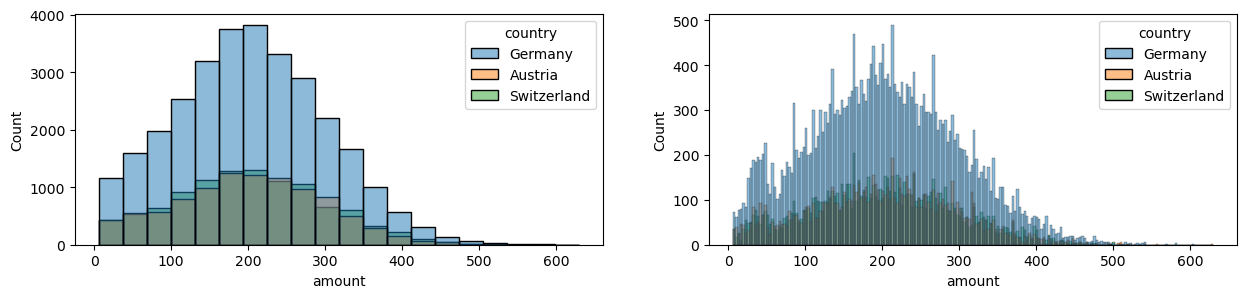

Scatter and strip plot - country and amount


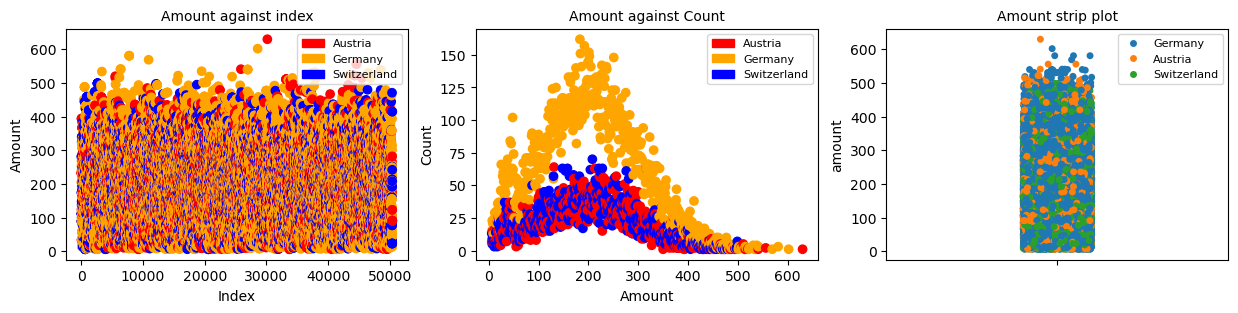

Compare success against country based on transactions count and values


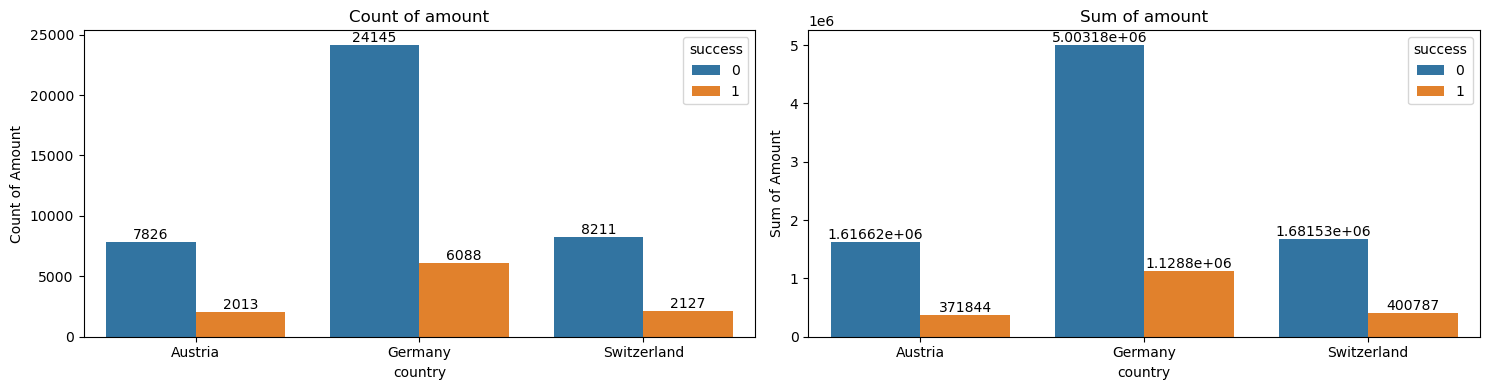

Stacked bar for success against country based on transactions count and values


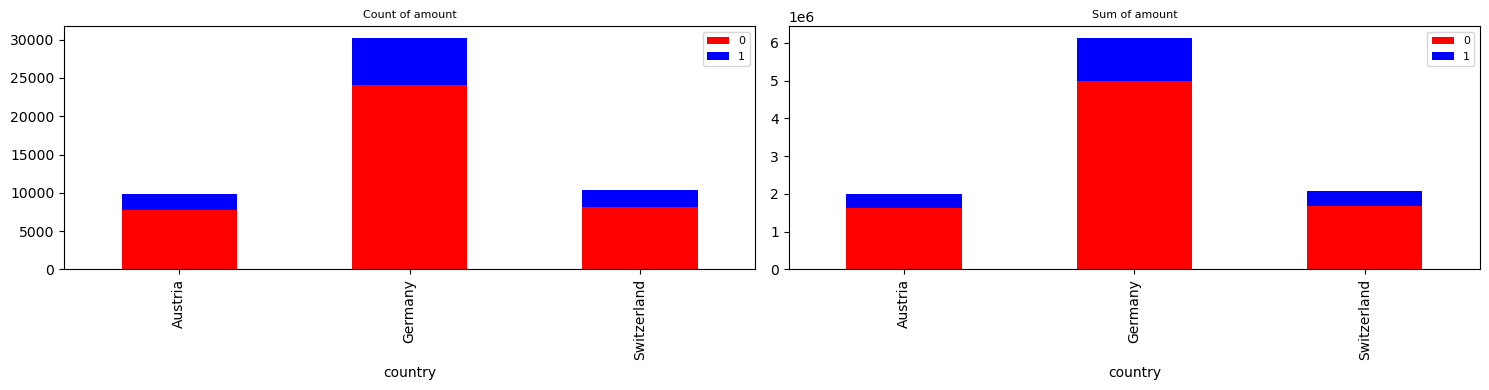

Success rate per country category
Success rate by category


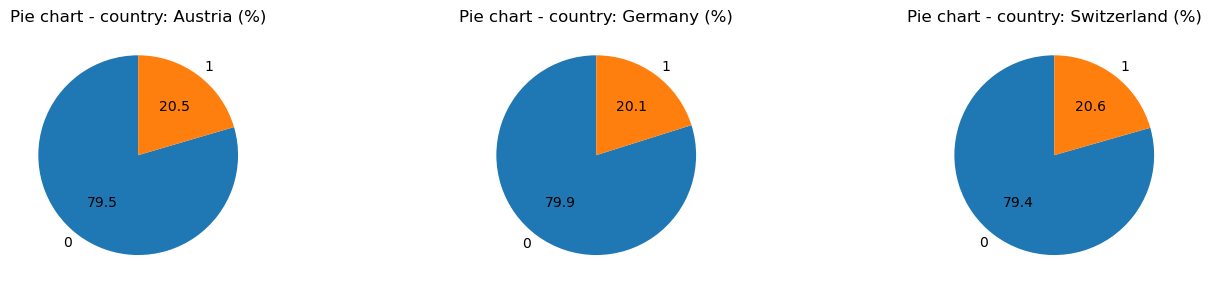

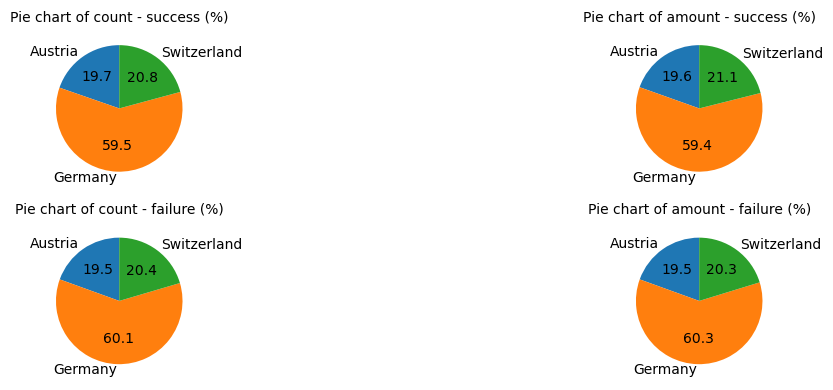

In [13]:
bivariate_analysis(dataset_time, 'country', {'Austria':'red', 'Germany':'orange', 'Switzerland':'blue'}, feature2='success')

##### aiii2. Success rate analysis

Histogram - success and amount


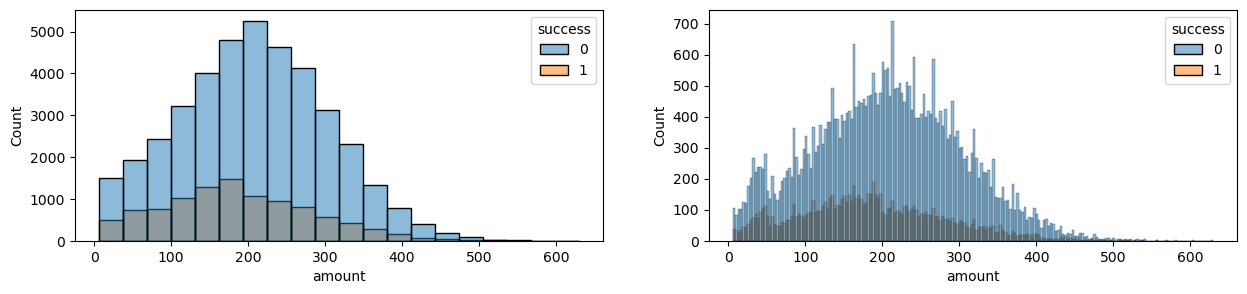

Scatter and strip plot - success and amount


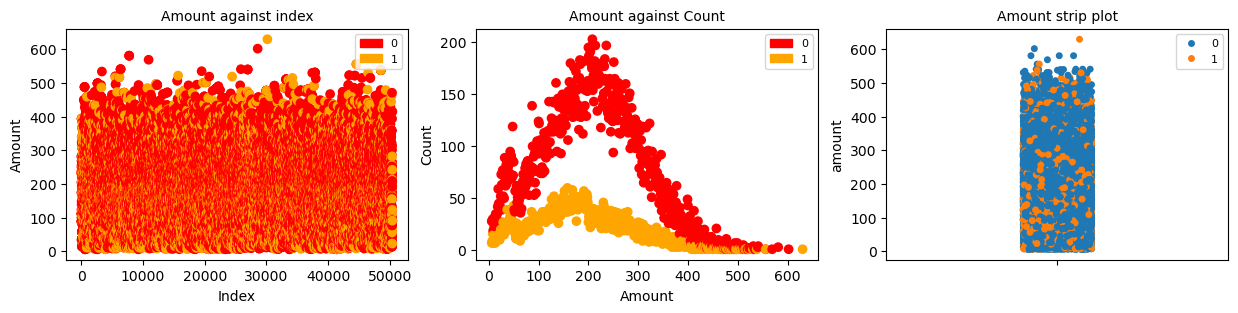

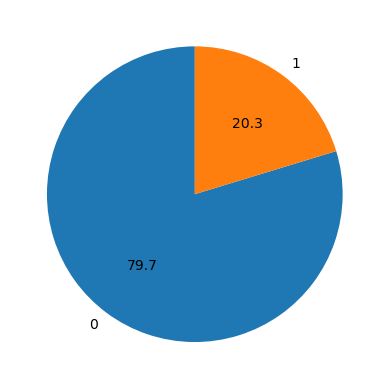

In [14]:
bivariate_analysis(dataset_time,'success', {0:'red', 1:'orange'})

##### aiii3. PSP against amount and success rate

Histogram - PSP and amount


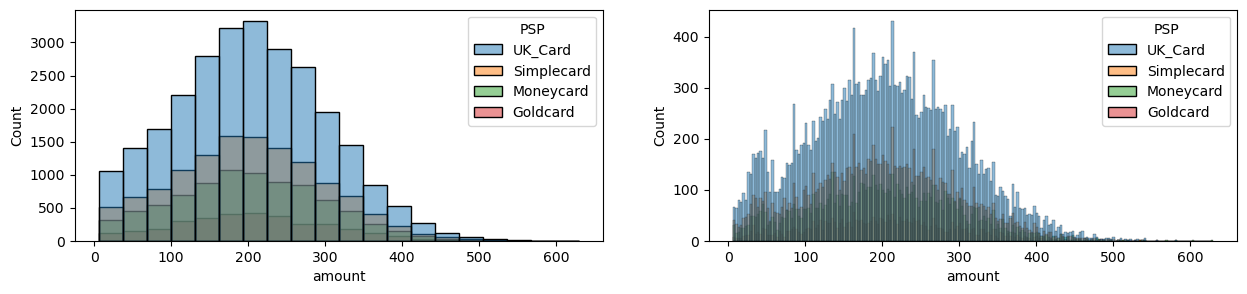

Scatter and strip plot - PSP and amount


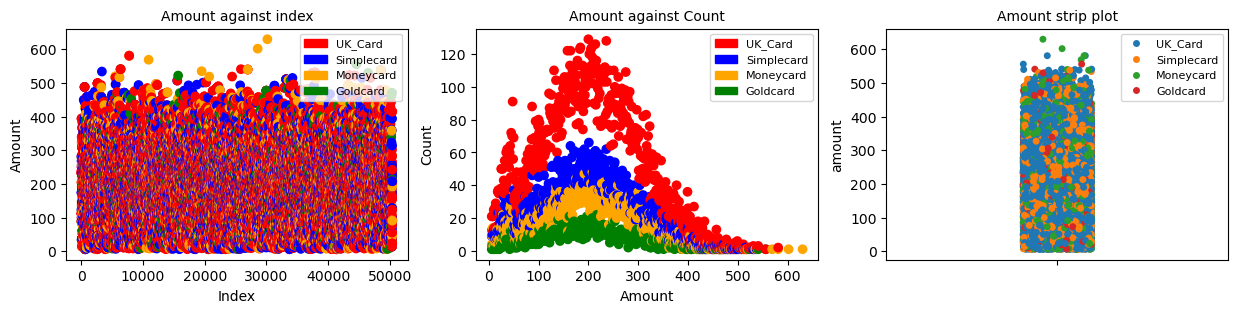

Compare success against PSP based on transactions count and values


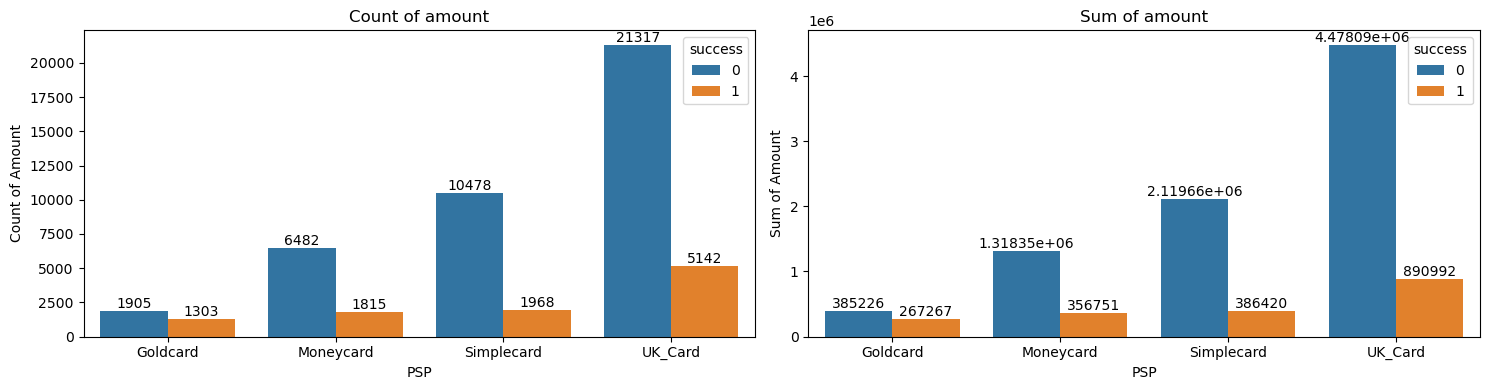

Stacked bar for success against PSP based on transactions count and values


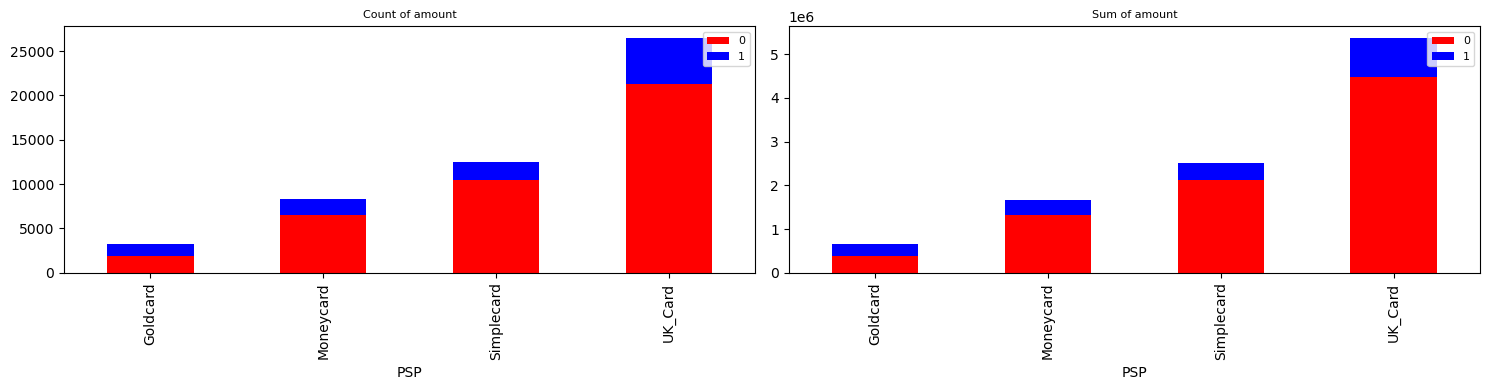

Success rate per PSP category
Success rate by category


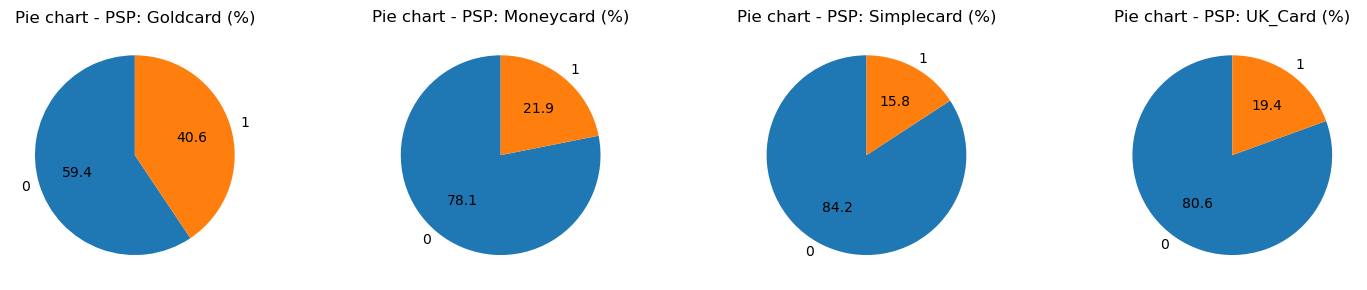

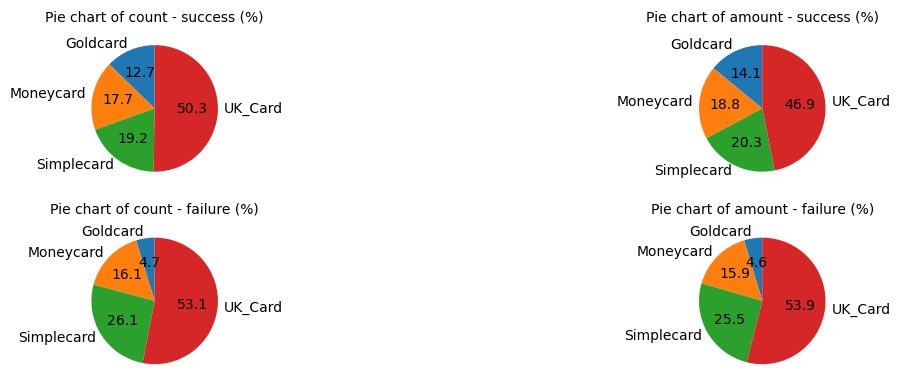

In [15]:
bivariate_analysis(dataset_time, 'PSP', {'UK_Card':'red', 'Simplecard':'blue', 'Moneycard':'orange','Goldcard':'green'}, feature2='success')

##### aiii4. 3D_secured against amount and success rate

Histogram - 3D_secured and amount


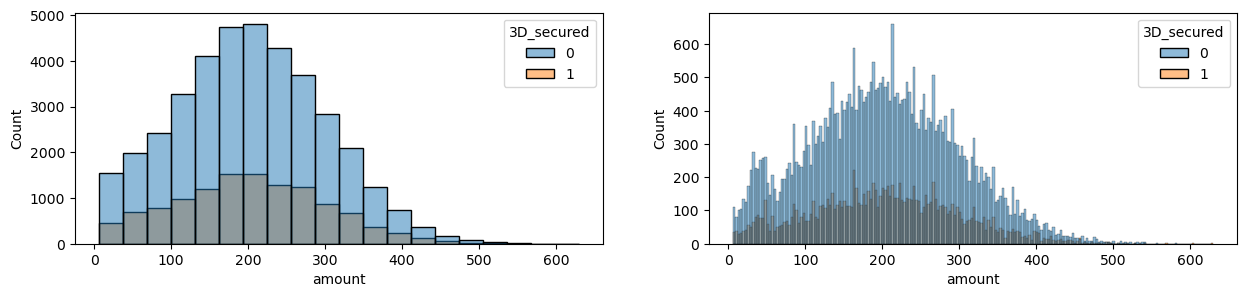

Scatter and strip plot - 3D_secured and amount


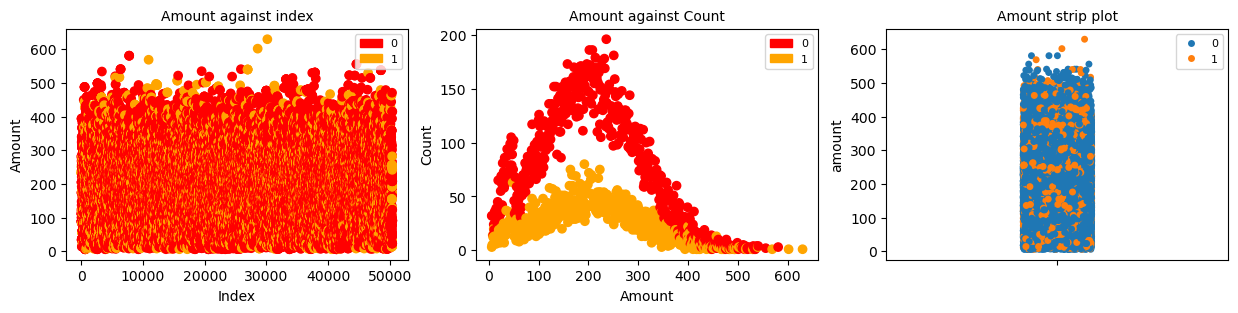

Compare success against 3D_secured based on transactions count and values


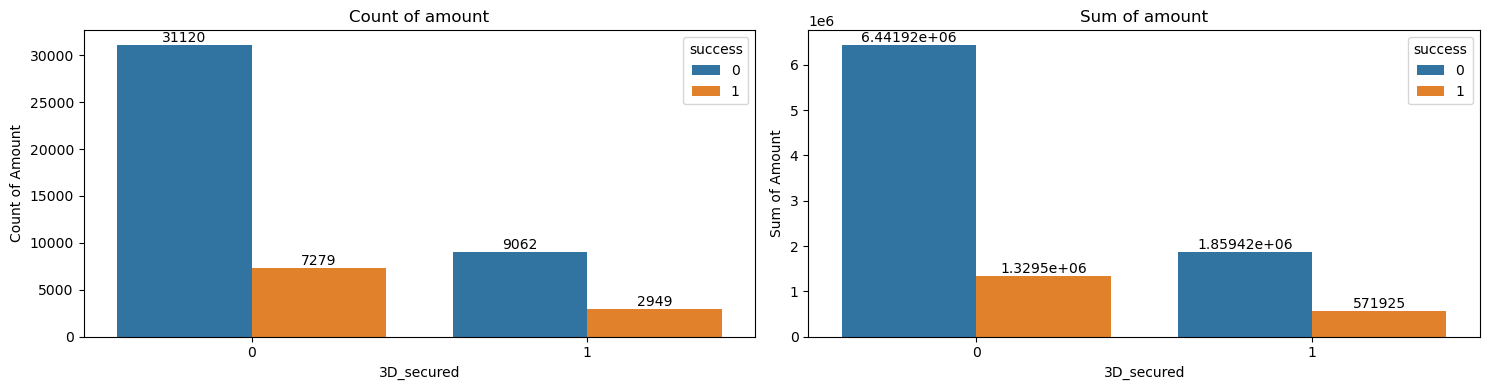

Stacked bar for success against 3D_secured based on transactions count and values


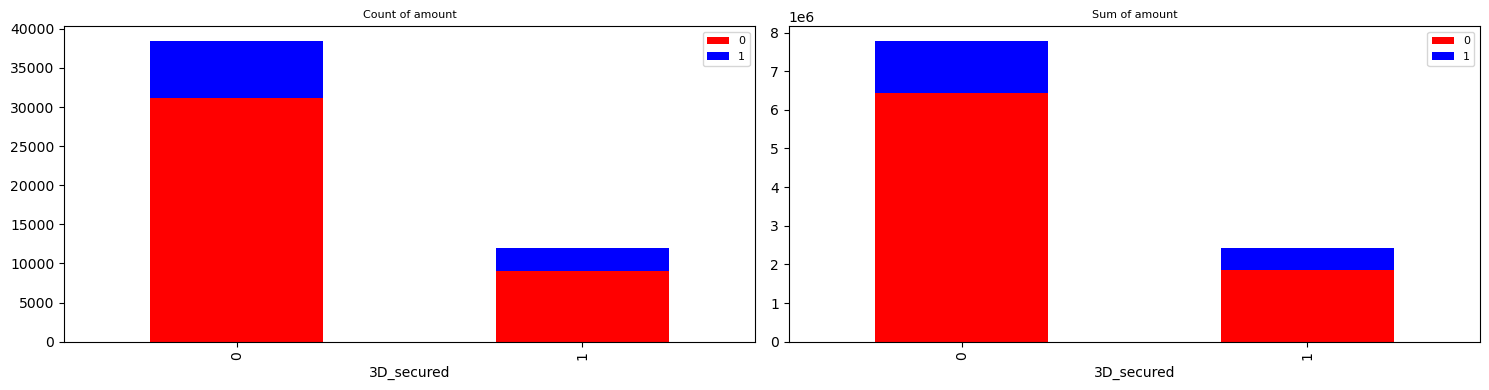

Success rate per 3D_secured category
Success rate by category


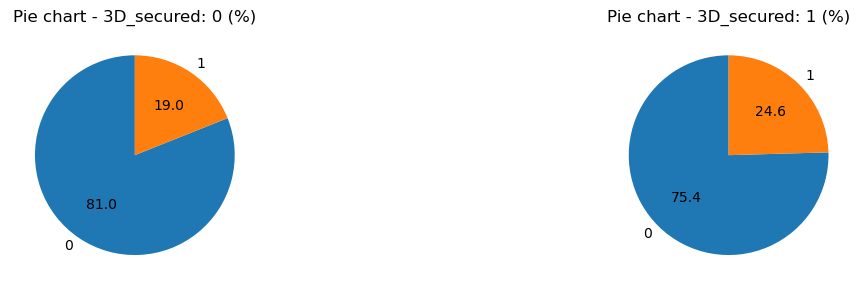

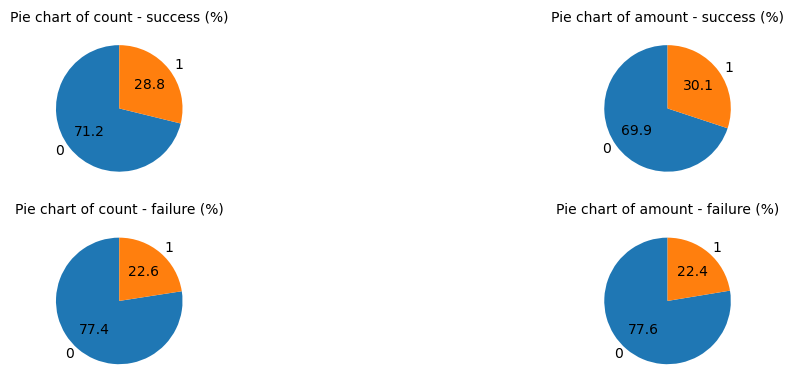

In [16]:
bivariate_analysis(dataset_time,'3D_secured', {0:'red', 1:'orange'}, feature2='success')

##### aiii5. Card against amount and success rate

Histogram - card and amount


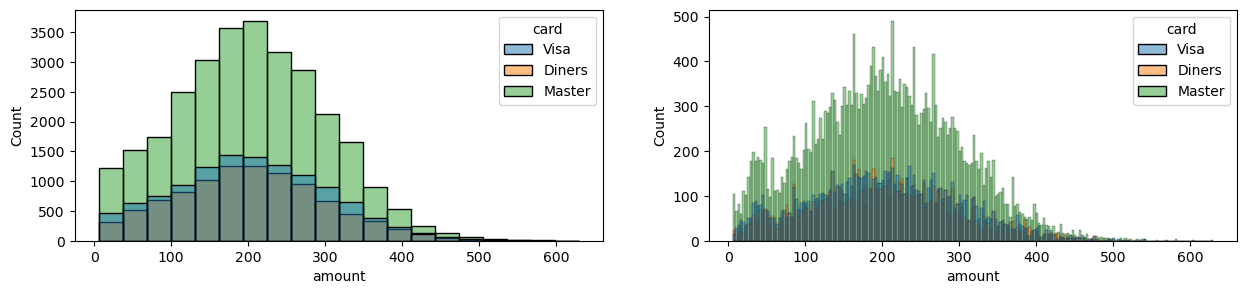

Scatter and strip plot - card and amount


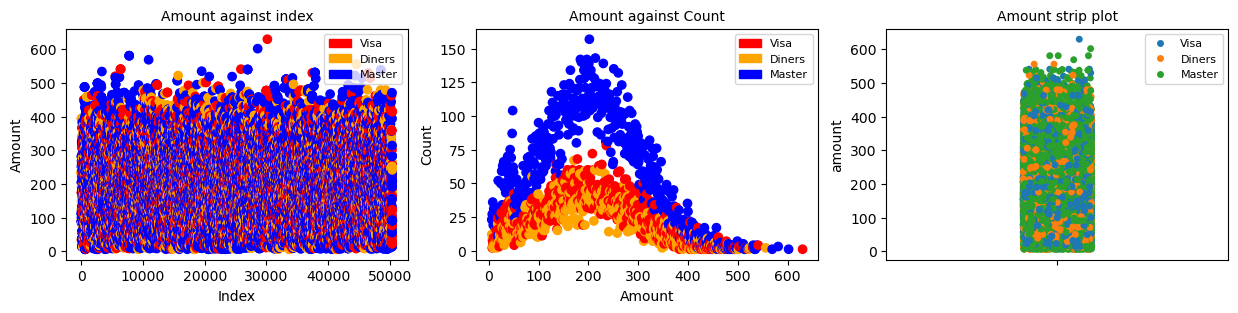

Compare success against card based on transactions count and values


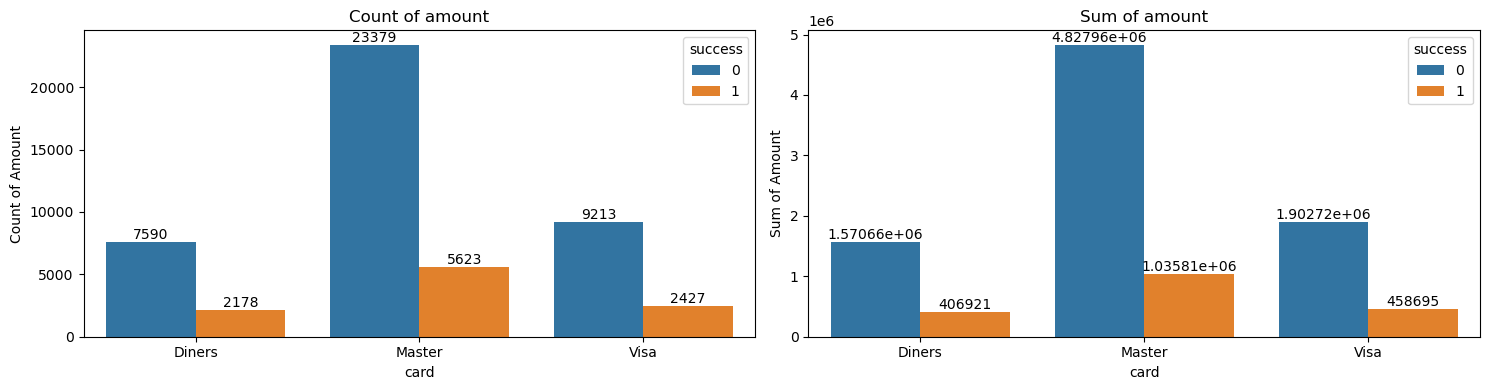

Stacked bar for success against card based on transactions count and values


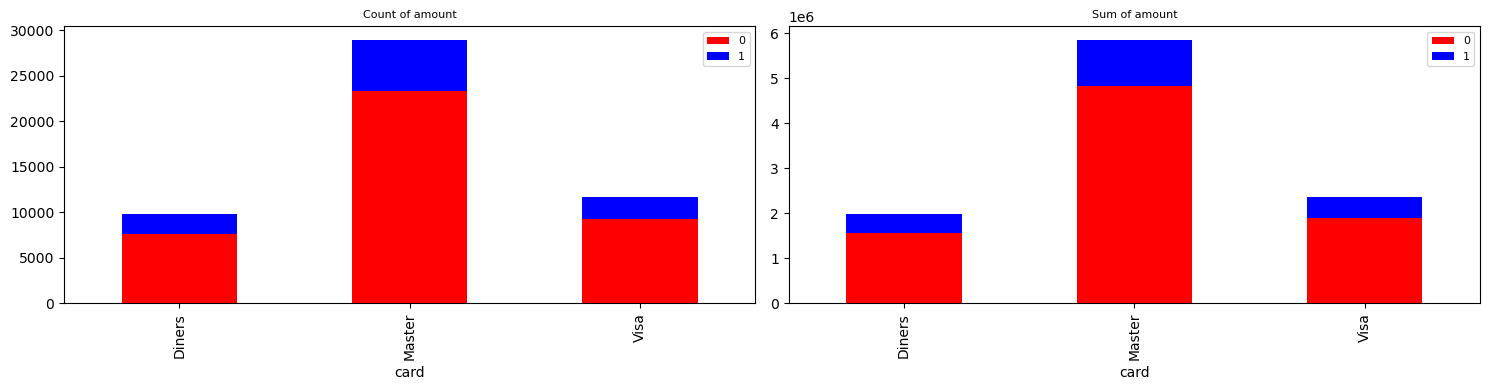

Success rate per card category
Success rate by category


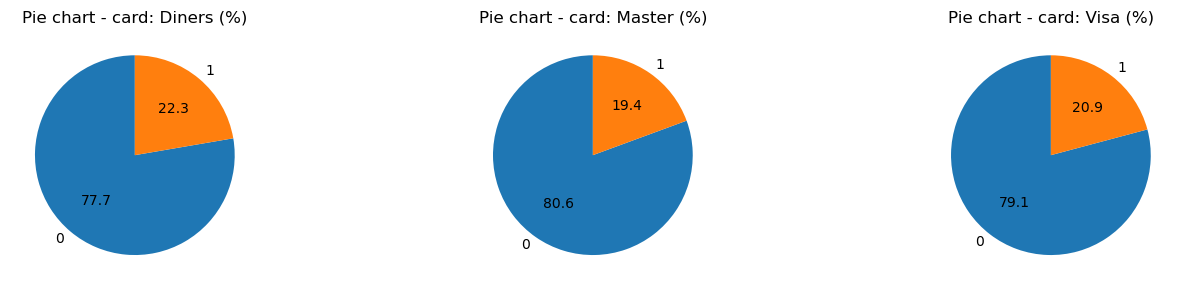

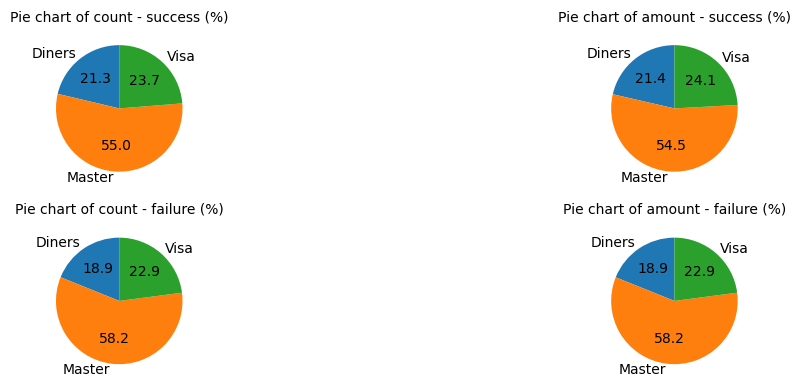

In [17]:
bivariate_analysis(dataset_time, 'card', {'Visa':'red', 'Diners':'orange', 'Master':'blue'}, feature2='success')

### 3aiv. Pairplot analysis

<Figure size 700x400 with 0 Axes>

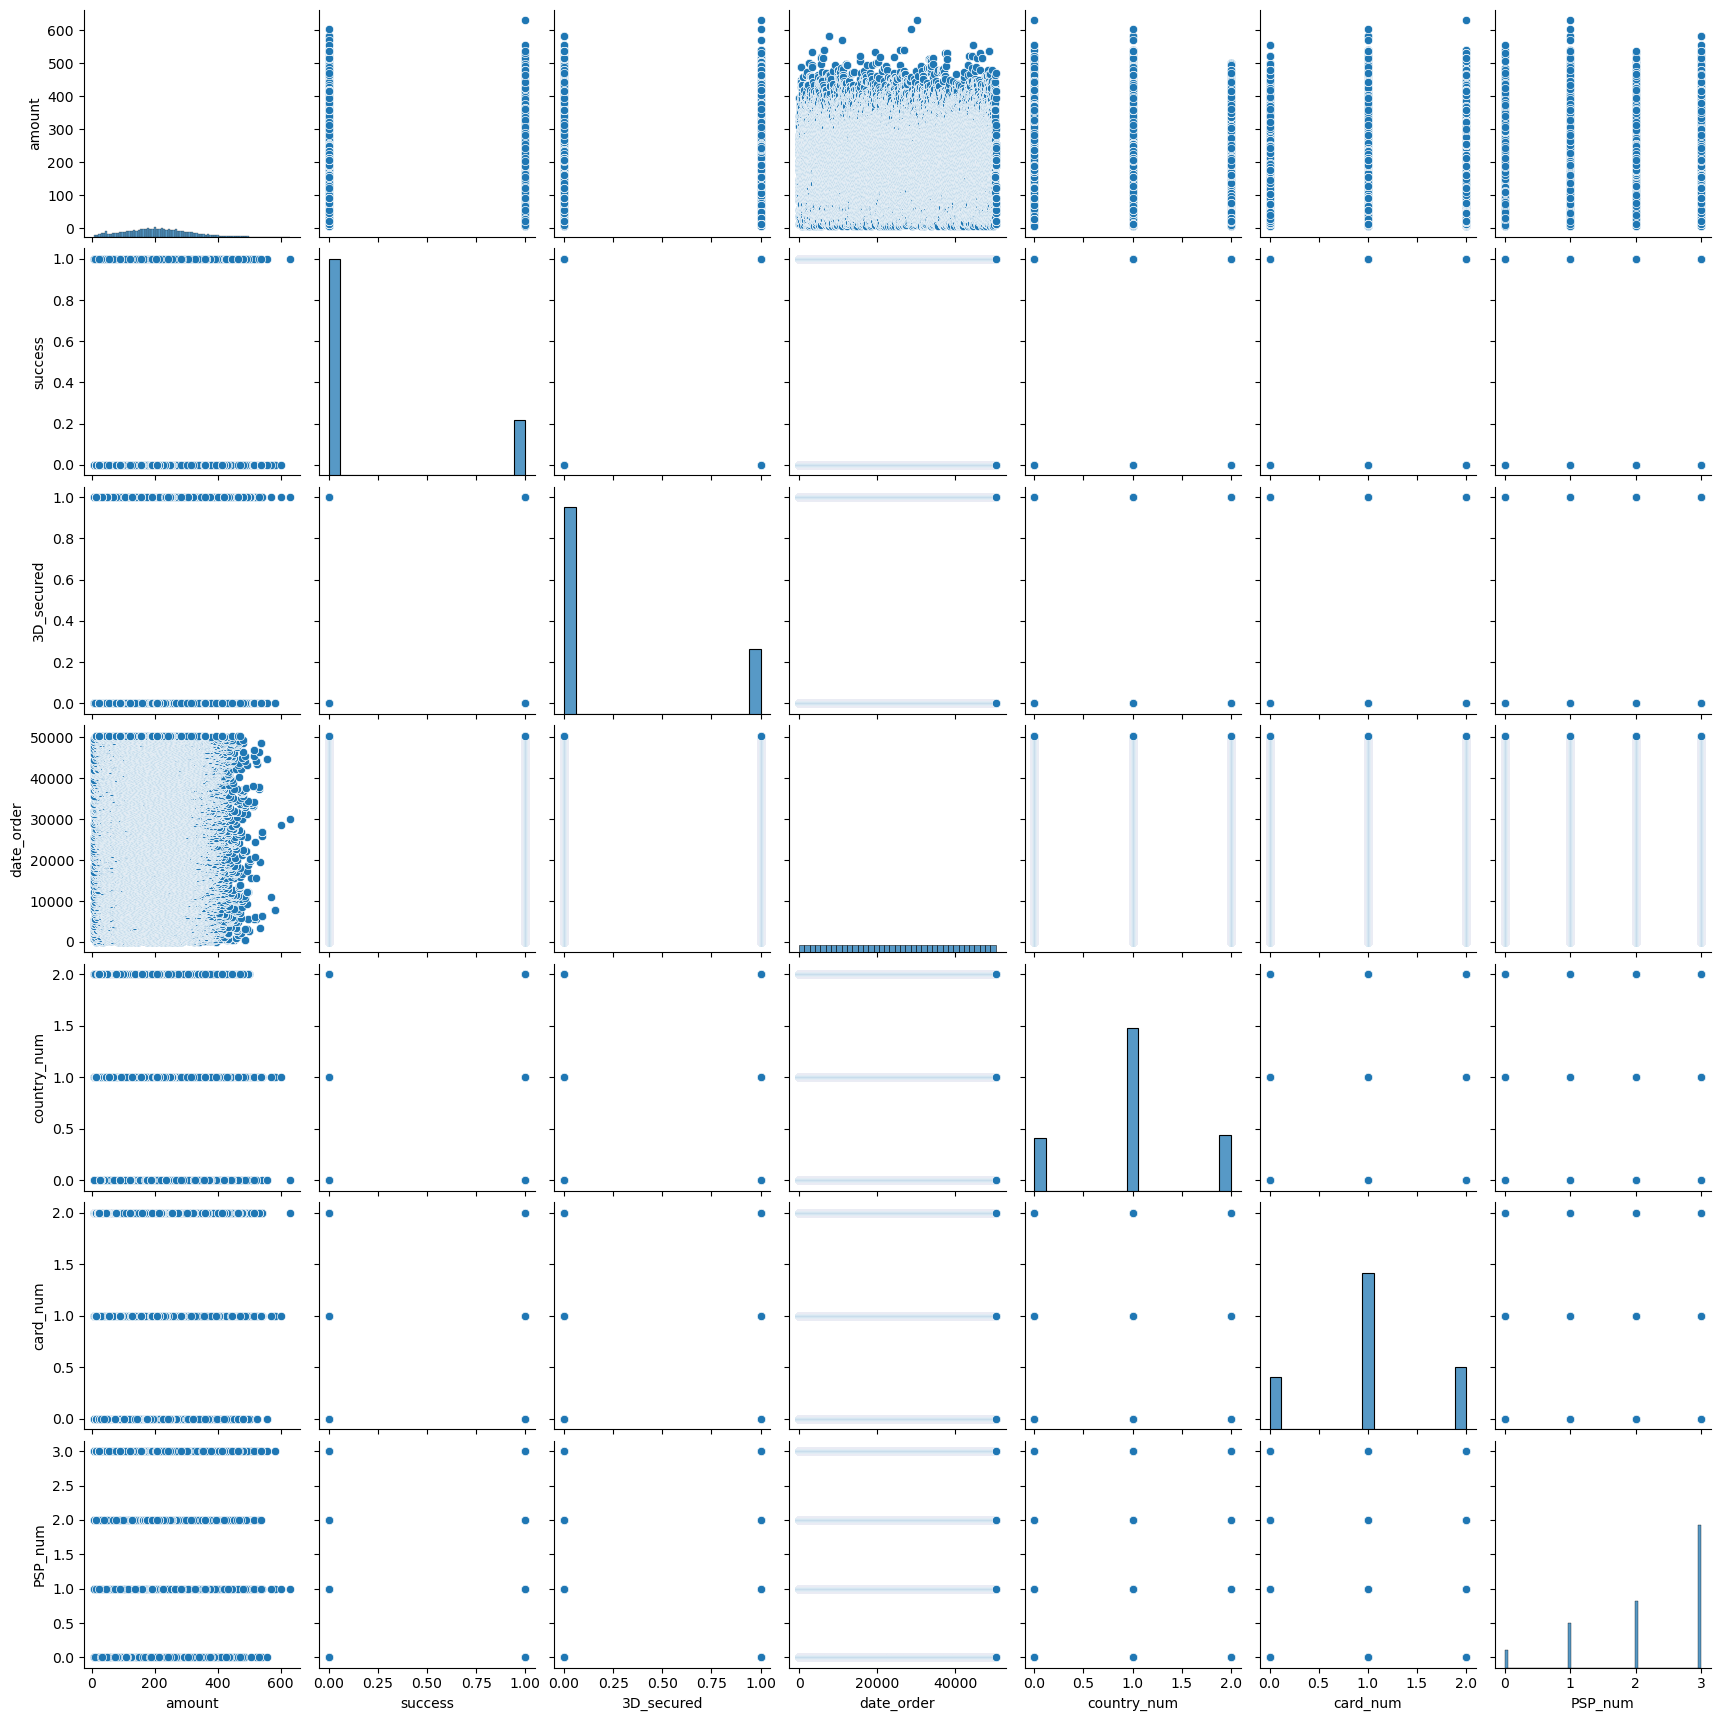

In [18]:
plt.figure(figsize = (7,4))
sns.pairplot(dataset_time)
plt.show()

<Figure size 700x400 with 0 Axes>

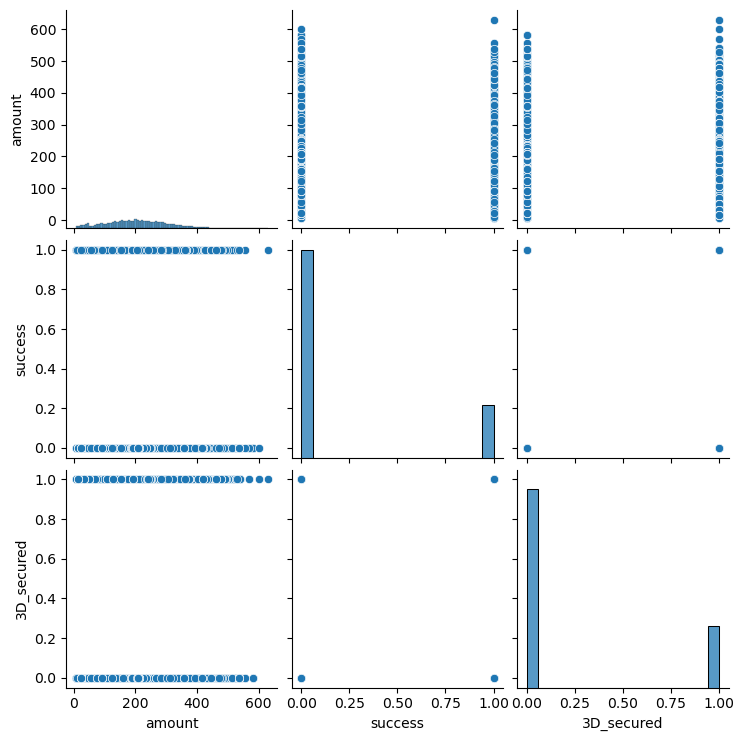

In [19]:
plt.figure(figsize = (7,4))
sns.pairplot(dataset_time.drop(['date_order', 'country_num', 'PSP_num', 'card_num'],axis=1))
plt.show()

### 3av. Correlation heatmap

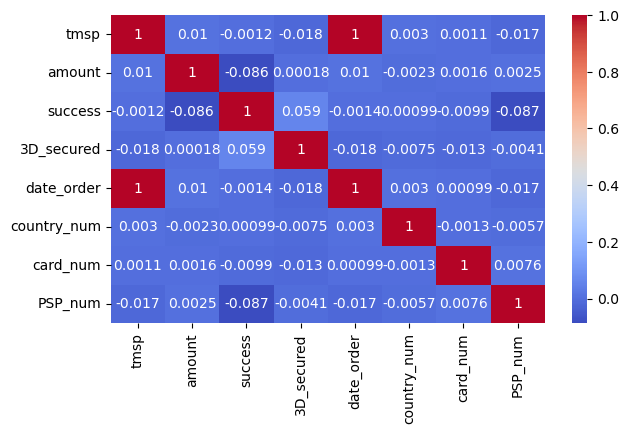

In [20]:
plt.figure(figsize = (7,4))
correlation_matrix = dataset_time.drop(['country', 'PSP', 'card'],axis=1).corr()
sns.heatmap(correlation_matrix, cmap = 'coolwarm', annot=True)
plt.show()

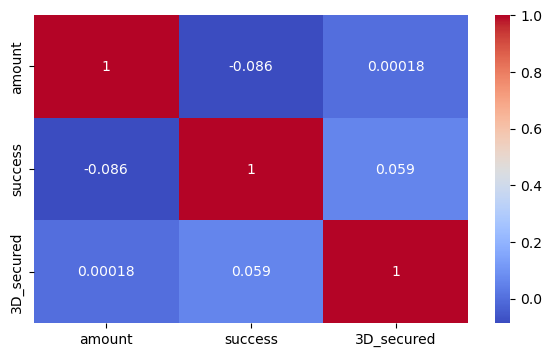

In [21]:
plt.figure(figsize = (7,4))
correlation_matrix = dataset_time.drop(['country', 'PSP', 'card', 'date_order', 'country_num', 'PSP_num', 'card_num', 'tmsp'],axis=1).corr()
sns.heatmap(correlation_matrix, cmap = 'coolwarm', annot=True)
plt.show()

### 3avi. Bivariate analysis of PSP against the other independent variables

##### avi1. PSP against country

Compare PSP against country based on transactions count and values


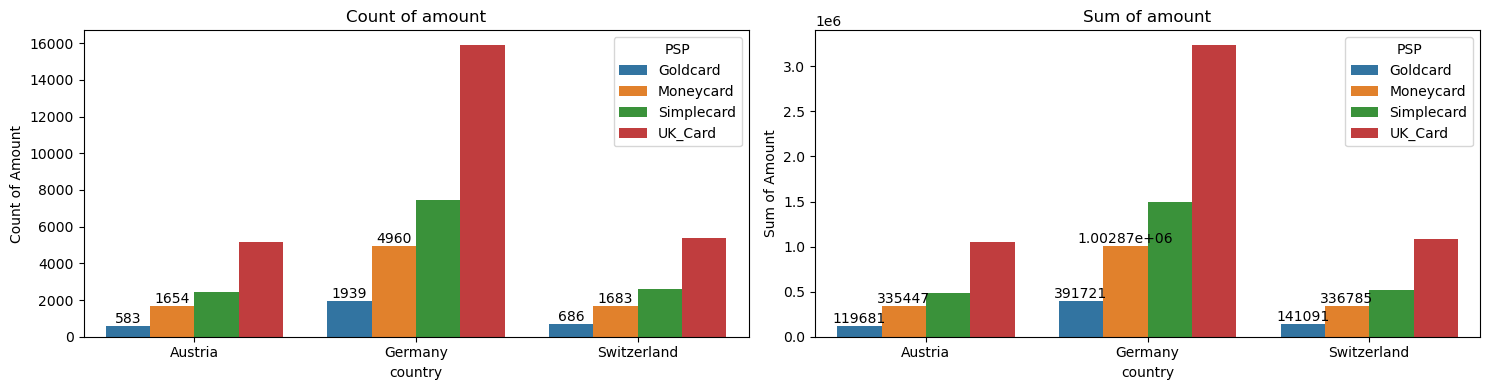

Stacked bar for PSP against country based on transactions count and values


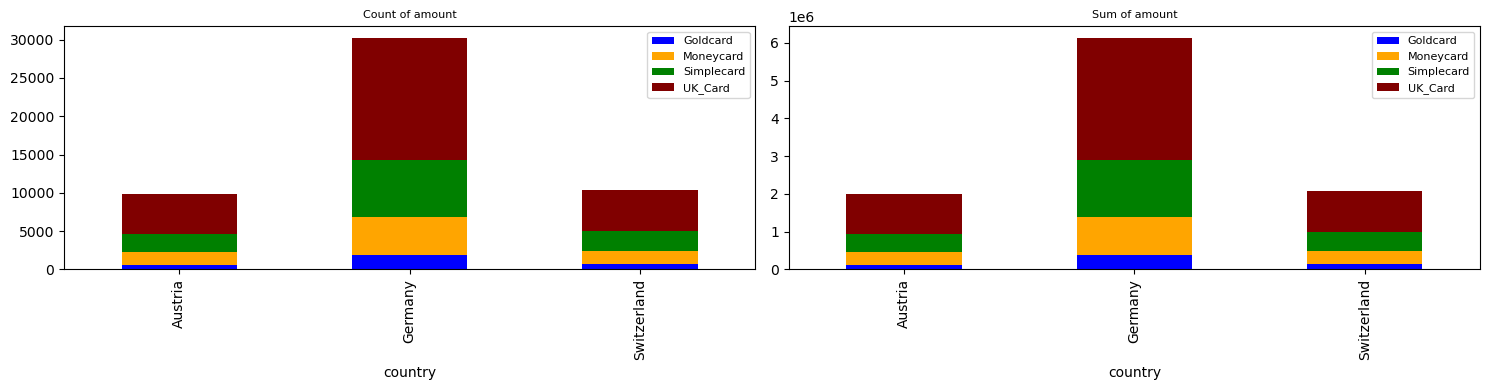

PSP per country category


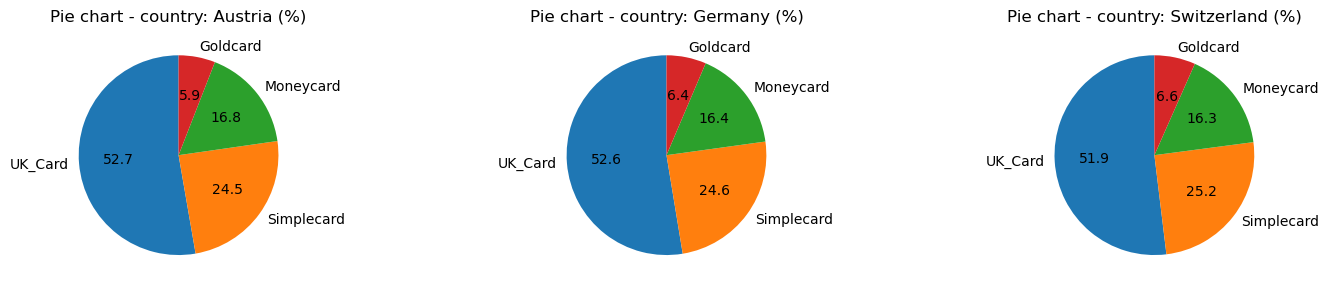

In [22]:
# PSP against country
bivariate_analysis(dataset_time, 'country', {'Austria':'red', 'Germany':'orange', 'Switzerland':'blue'}, feature2='PSP', 
                   color_list=['blue', 'orange', 'green', 'maroon'])

##### avi2. PSP against success

Compare PSP against success based on transactions count and values


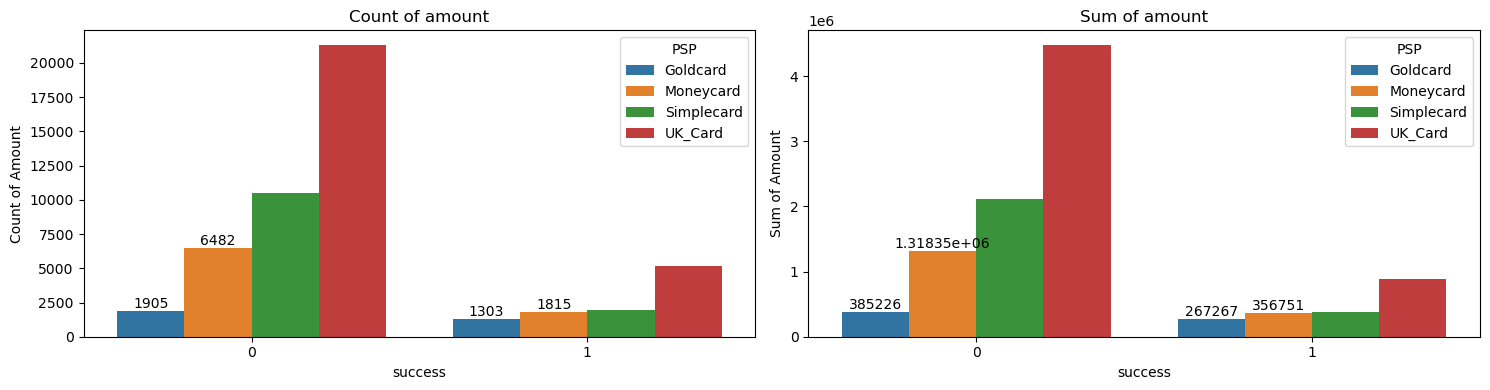

Stacked bar for PSP against success based on transactions count and values


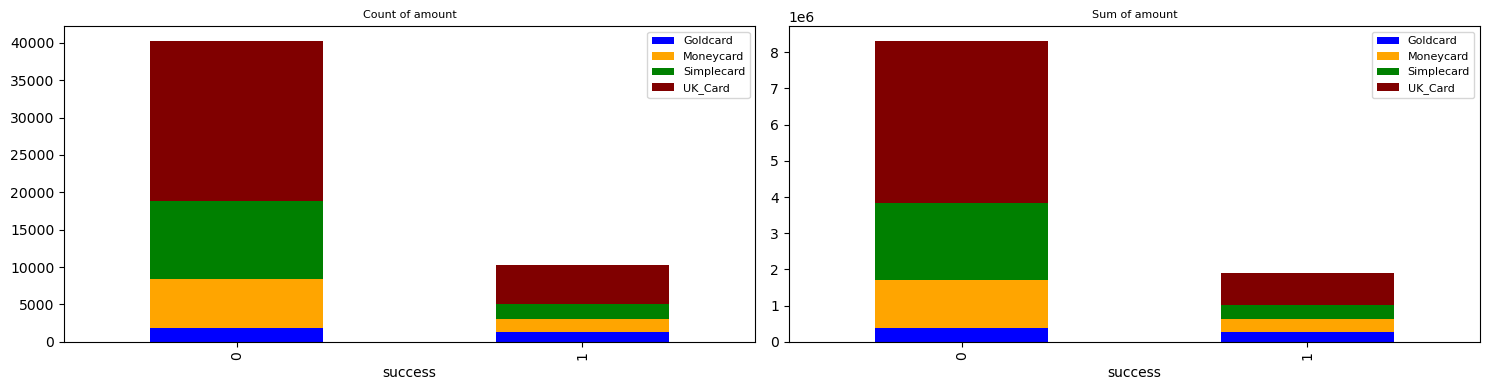

PSP per success category


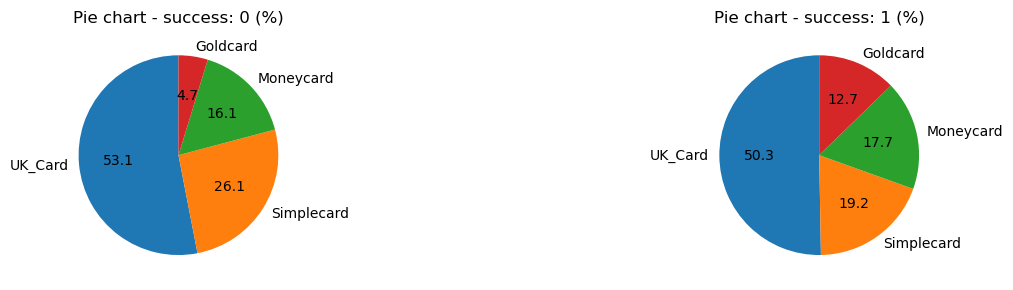

In [23]:
# PSP against success
bivariate_analysis(dataset_time,'success', {0:'red', 1:'orange'}, feature2='PSP', color_list=['blue', 'orange', 'green', 'maroon'])

##### avi3. PSP against 3D_secured

Compare PSP against 3D_secured based on transactions count and values


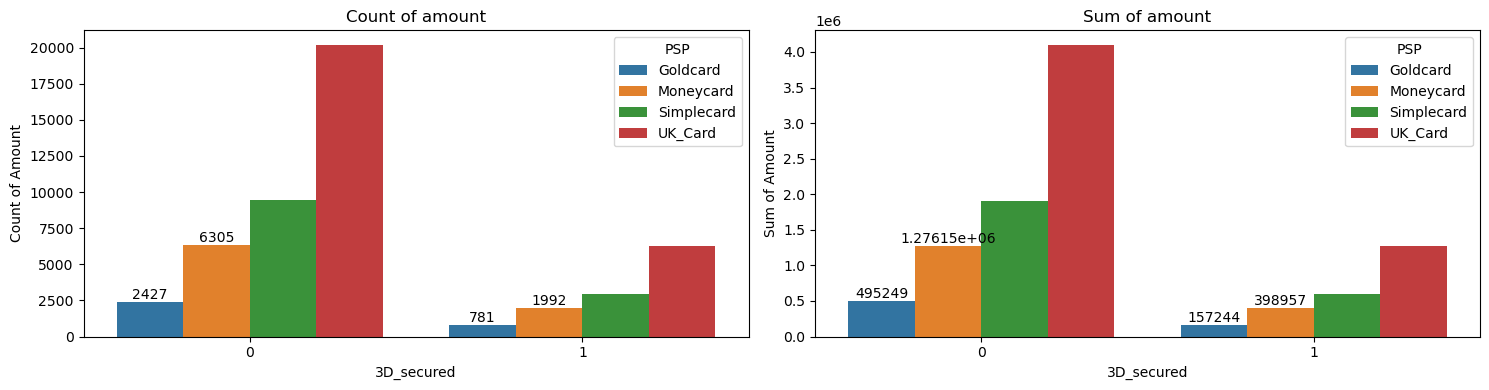

Stacked bar for PSP against 3D_secured based on transactions count and values


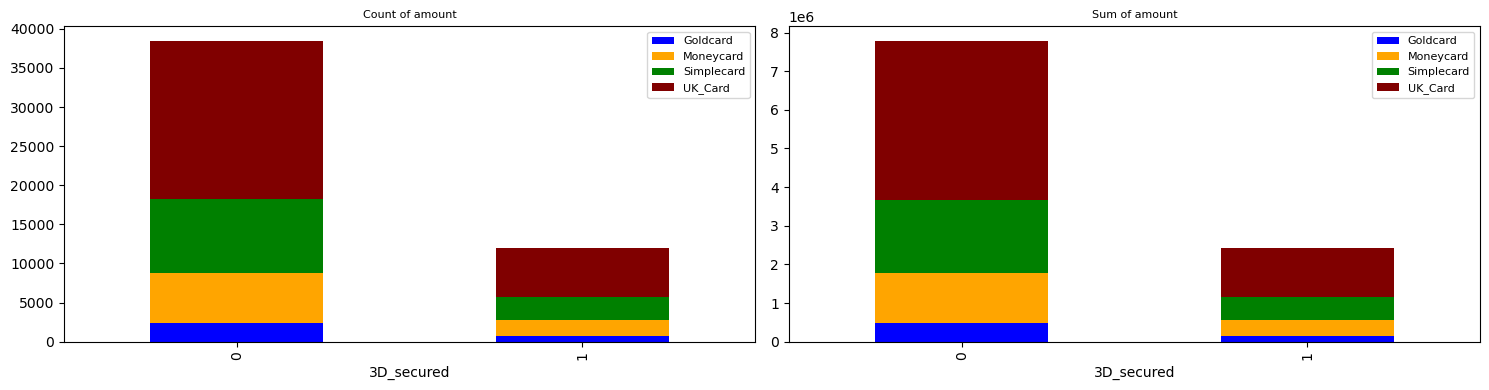

PSP per 3D_secured category


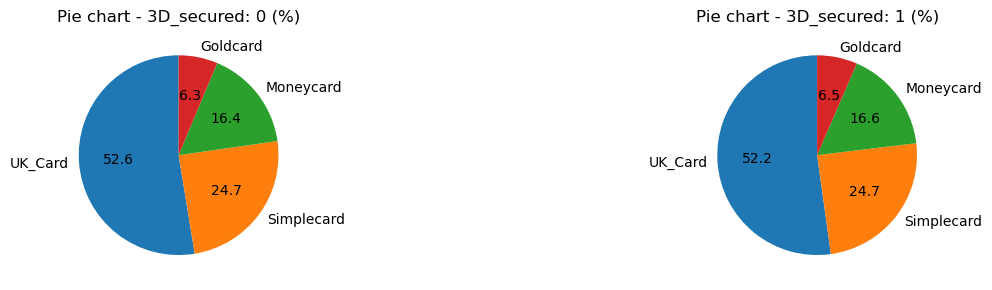

In [24]:
# PSP against 3D_secured
bivariate_analysis(dataset_time,'3D_secured', {0:'red', 1:'orange'}, feature2='PSP', color_list=['blue', 'orange', 'green', 'maroon'])

##### avi4. PSP against card

Compare PSP against card based on transactions count and values


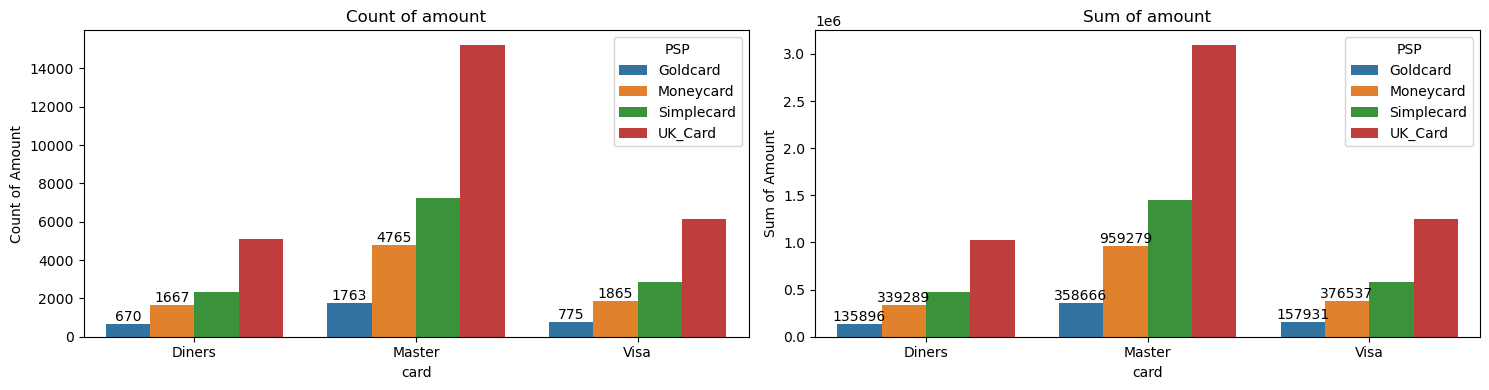

Stacked bar for PSP against card based on transactions count and values


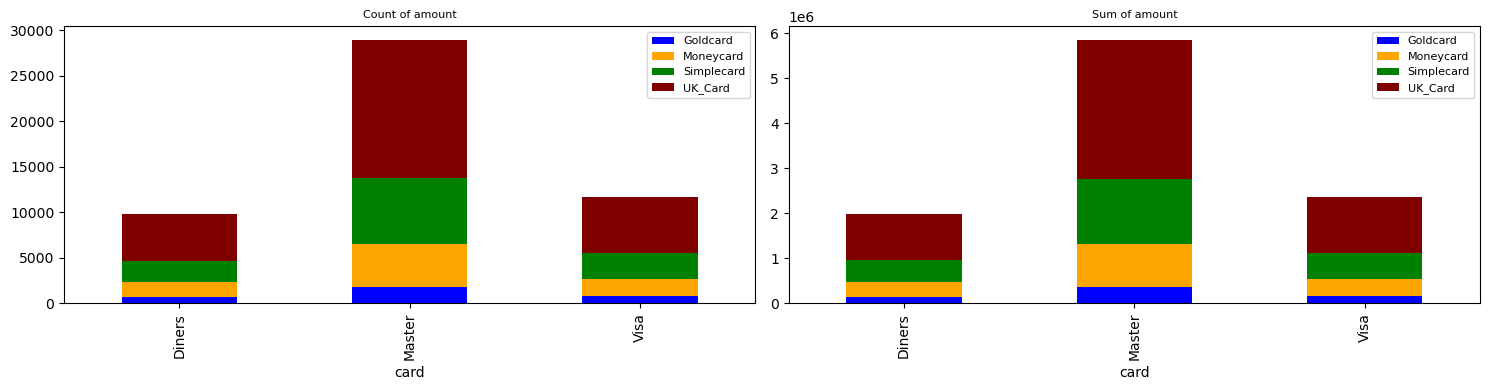

PSP per card category


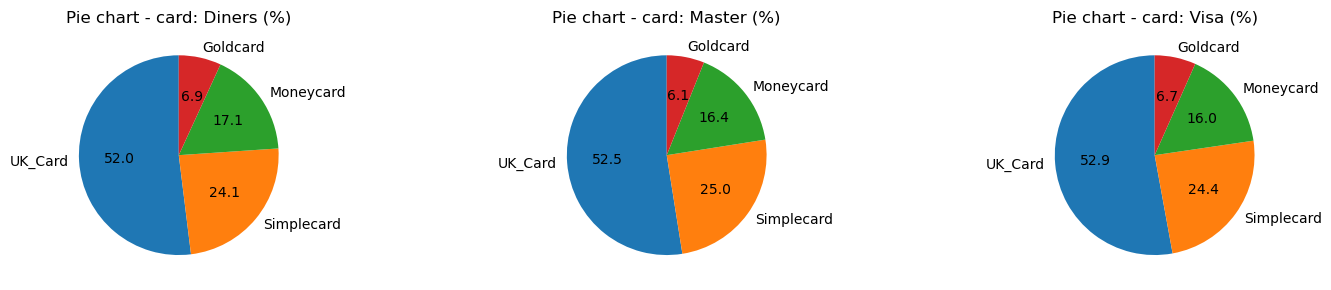

In [25]:
# PSP against card
bivariate_analysis(dataset_time, 'card', {'Visa':'red', 'Diners':'orange', 'Master':'blue'}, feature2='PSP', 
                   color_list=['blue', 'orange', 'green', 'maroon'])

### 3avii. Bivariate analysis of 3D_secured against PSP

##### avii1. 3D_secured against PSP

Compare 3D_secured against PSP based on transactions count and values


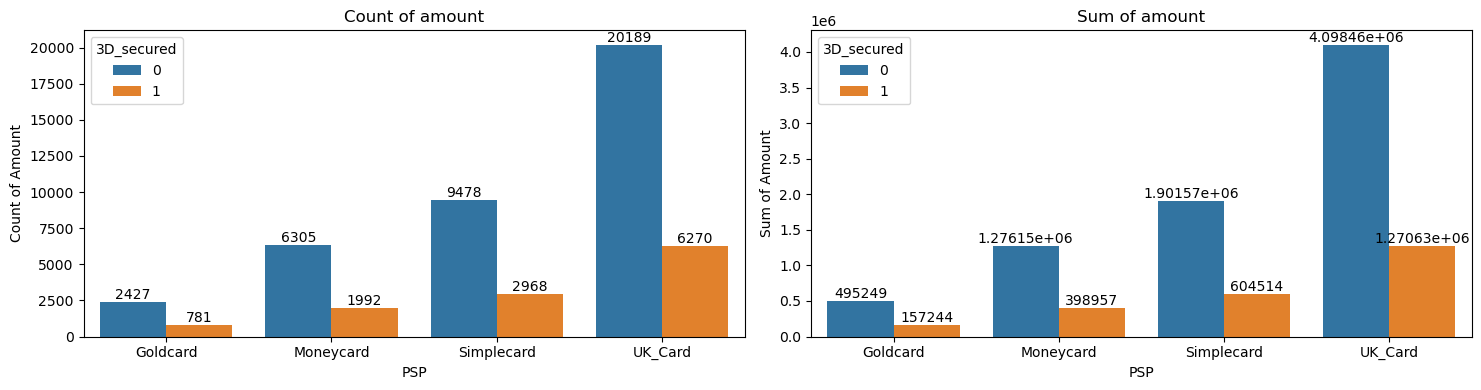

Stacked bar for 3D_secured against PSP based on transactions count and values


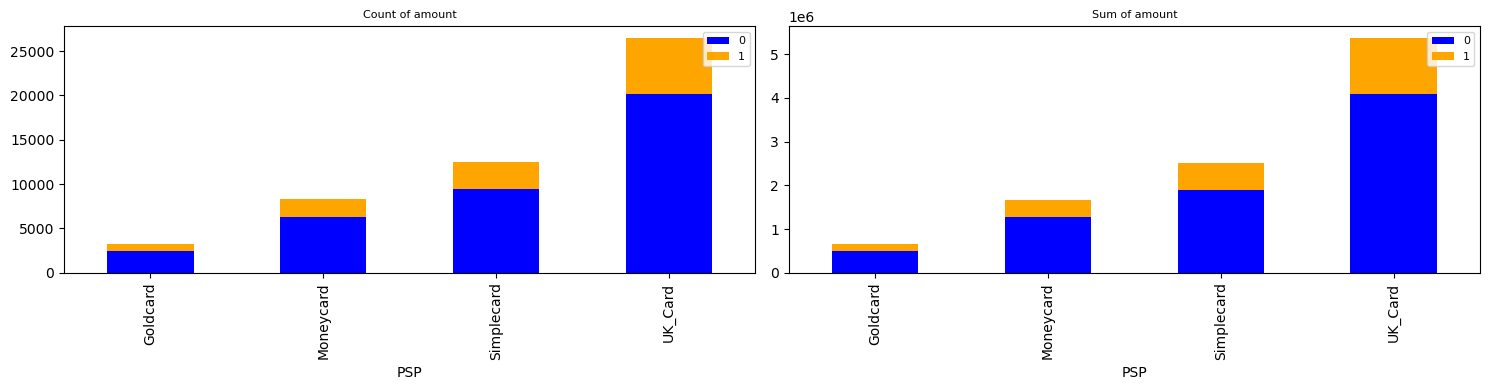

3D_secured per PSP category


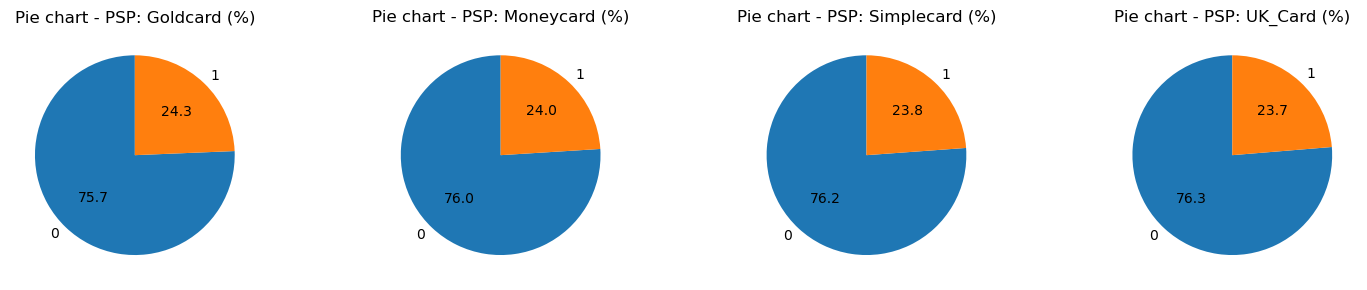

In [26]:
# PSP against card
bivariate_analysis(dataset_time, 'PSP', {'UK_Card':'red', 'Simplecard':'blue', 'Moneycard':'orange','Goldcard':'green'}, feature2='3D_secured', 
                   color_list=['blue', 'orange', 'green', 'maroon'], labels=['0', '1'])

##### avii2. 3D_secured against PSP for failed transactions only

Compare 3D_secured against PSP based on transactions count and values


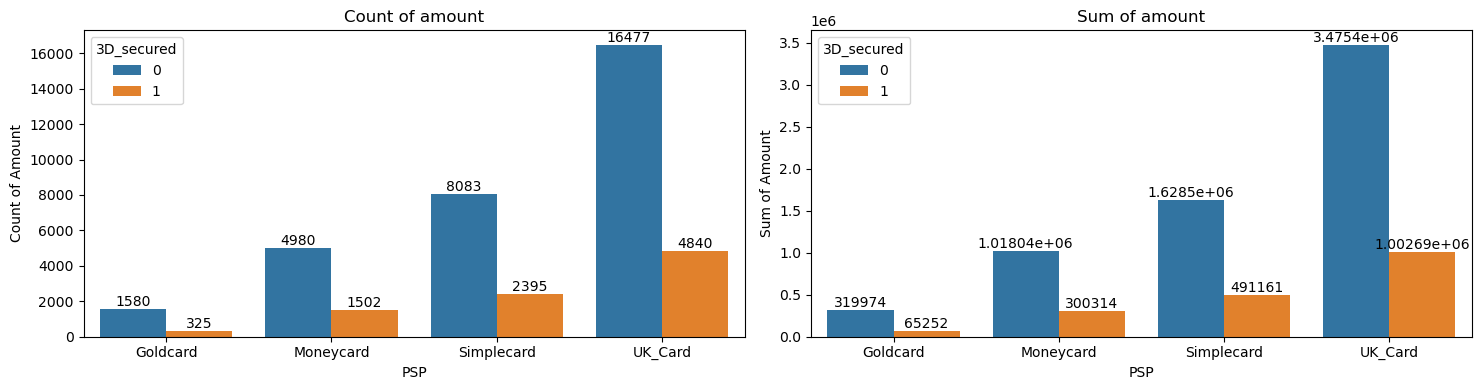

Stacked bar for 3D_secured against PSP based on transactions count and values


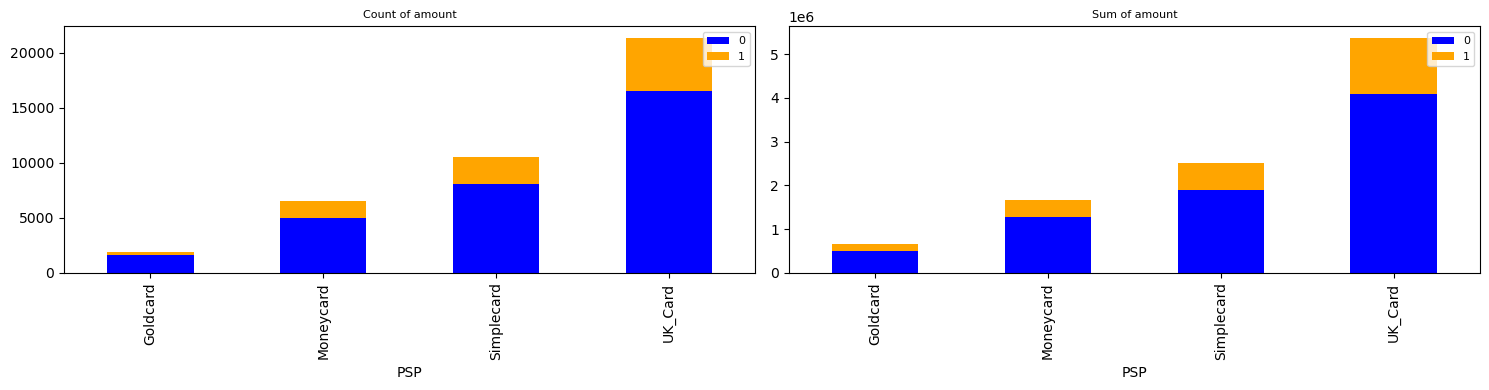

3D_secured per PSP category


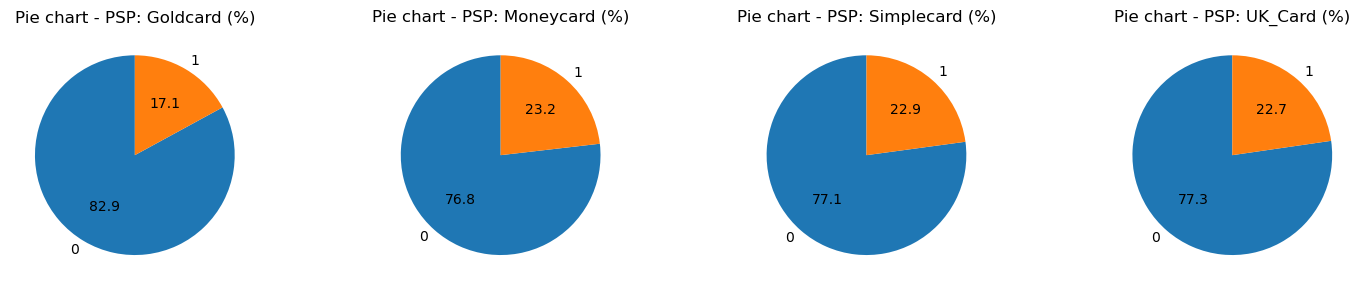

In [27]:
bivariate_analysis(dataset_time[dataset_time['success']==0], 'PSP', {'UK_Card':'red', 'Simplecard':'blue', 'Moneycard':'orange','Goldcard':'green'}, 
                   feature2='3D_secured', color_list=['blue', 'orange', 'green', 'maroon'], labels=['0', '1'])

##### avii3. 3D_secured against PSP for successful transactions only

Compare 3D_secured against PSP based on transactions count and values


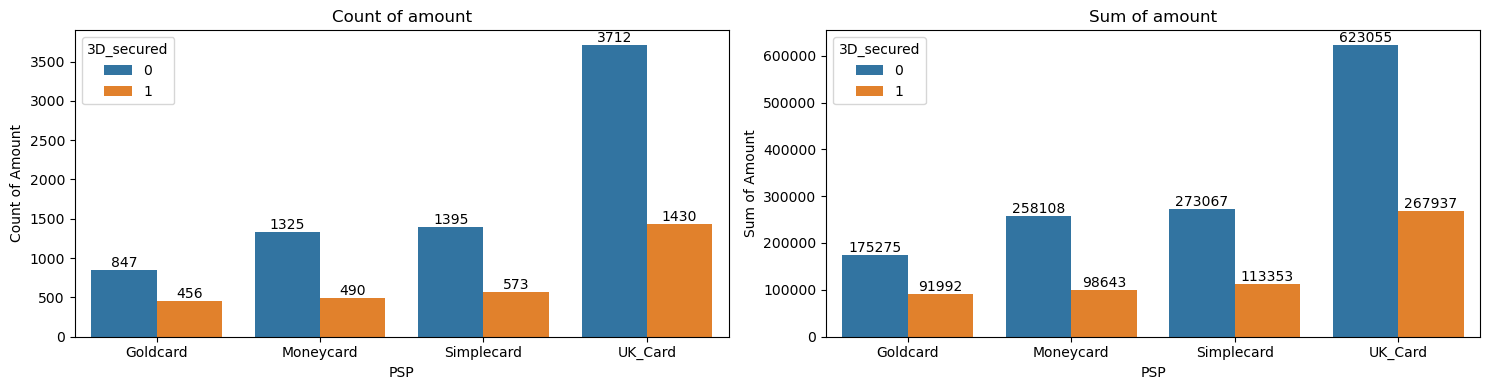

Stacked bar for 3D_secured against PSP based on transactions count and values


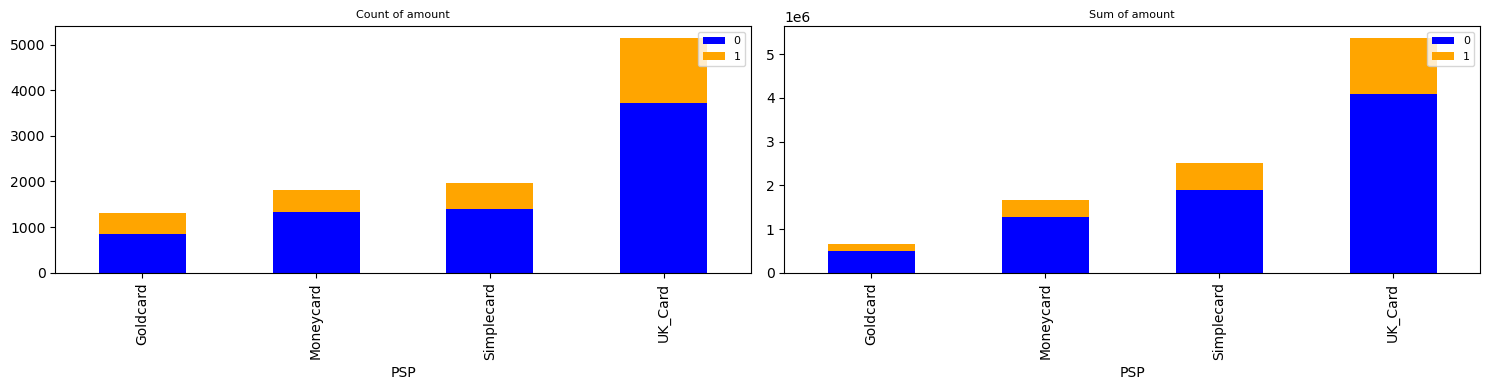

3D_secured per PSP category


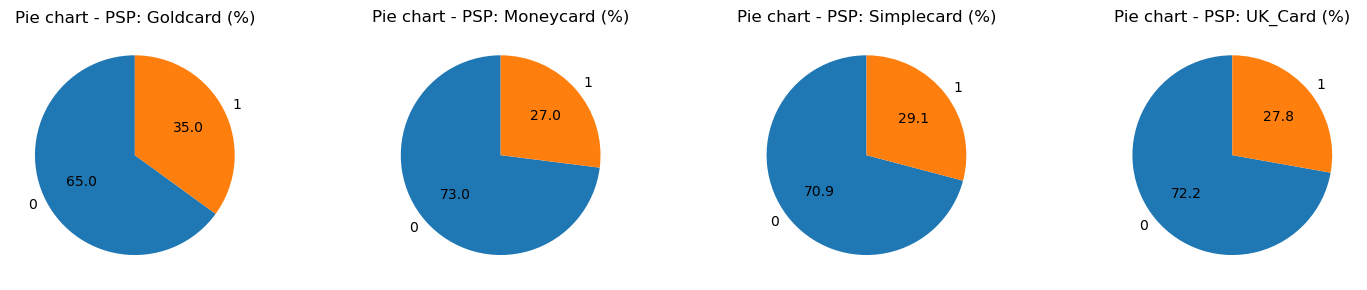

In [28]:
bivariate_analysis(dataset_time[dataset_time['success']==1], 'PSP', {'UK_Card':'red', 'Simplecard':'blue', 'Moneycard':'orange','Goldcard':'green'}, 
                   feature2='3D_secured', color_list=['blue', 'orange', 'green', 'maroon'], labels=['0', '1'])

## PART 3b: Bivariate Analysis without duplicate transactions included

### 3bi. Data Preparation Steps

##### bi1. Read Dataset and update index

In [29]:
dataset = pd.read_excel("PSP_Jan_Feb_2019.xlsx")

In [30]:
dataset.head()

Unnamed: 0                tmsp  country  amount  success         PSP  \
0           0 2019-01-01 00:01:11  Germany      89        0     UK_Card   
1           1 2019-01-01 00:01:17  Germany      89        1     UK_Card   
2           2 2019-01-01 00:02:49  Germany     238        0     UK_Card   
3           3 2019-01-01 00:03:13  Germany     238        1     UK_Card   
4           4 2019-01-01 00:04:33  Austria     124        0  Simplecard   

   3D_secured    card  
0           0    Visa  
1           0    Visa  
2           1  Diners  
3           1  Diners  
4           0  Diners

In [31]:
dataset = dataset.drop('Unnamed: 0', axis=1)

In [32]:
dataset.head(1)

tmsp  country  amount  success      PSP  3D_secured  card
0 2019-01-01 00:01:11  Germany      89        0  UK_Card           0  Visa

##### bi2. Remove duplicates

In [33]:
dataset.sort_values(["tmsp", "country", "amount"], axis = 0, ascending = True, inplace = True, na_position = "first")

In [34]:
dataset.reset_index(inplace=True, drop=True)

In [35]:
dataset.head(2)

tmsp  country  amount  success      PSP  3D_secured  card
0 2019-01-01 00:01:11  Germany      89        0  UK_Card           0  Visa
1 2019-01-01 00:01:17  Germany      89        1  UK_Card           0  Visa

In [36]:
dataset["time_delta"] = (dataset["tmsp"]-dataset["tmsp"].shift(1)).dt.total_seconds()

In [37]:
dataset["time_delta"] = dataset["time_delta"].fillna(0)

In [38]:
same_tx = (dataset["time_delta"]>60).cumsum()
dataset['tx_number'] = dataset.groupby(same_tx).ngroup()

In [39]:
dataset.head(1)

tmsp  country  amount  success      PSP  3D_secured  card  \
0 2019-01-01 00:01:11  Germany      89        0  UK_Card           0  Visa   

   time_delta  tx_number  
0         0.0          0

In [40]:
dataset.drop_duplicates(subset=['tx_number', 'PSP'], keep='first', inplace=True)

##### bi3. Update index and data preparation

In [41]:
# make timestamp the index for easier analysis
dataset = dataset.set_index(dataset.columns[0])

In [42]:
dataset.head(2)

country  amount  success      PSP  3D_secured    card  \
tmsp                                                                         
2019-01-01 00:01:11  Germany      89        0  UK_Card           0    Visa   
2019-01-01 00:02:49  Germany     238        0  UK_Card           1  Diners   

                     time_delta  tx_number  
tmsp                                        
2019-01-01 00:01:11         0.0          0  
2019-01-01 00:02:49        92.0          1

In [43]:
# add a feature field to hold the order of the dates - for the base model
dataset['date_order'] = np.arange(len(dataset.index))

In [44]:
# reset_dataset
dataset_time = dataset.copy().reset_index()
dataset_time.head(1)

tmsp  country  amount  success      PSP  3D_secured  card  \
0 2019-01-01 00:01:11  Germany      89        0  UK_Card           0  Visa   

   time_delta  tx_number  date_order  
0         0.0          0           0

### 3bii. Create dummy numeric variables for categorical variables

In [45]:
dataset_time['country_num'] = dataset_time['country'].apply(encode_country)
dataset_time['card_num'] = dataset_time['card'].apply(encode_card)
dataset_time['PSP_num'] = dataset_time['PSP'].apply(encode_PSP)

### 3biii. Bivariate analysis of all variables

##### biii1. Country against amount and success rate

Histogram - country and amount


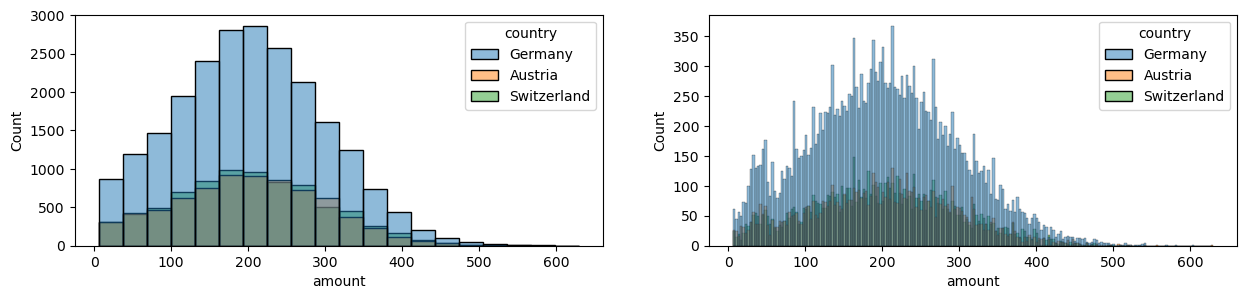

Scatter and strip plot - country and amount


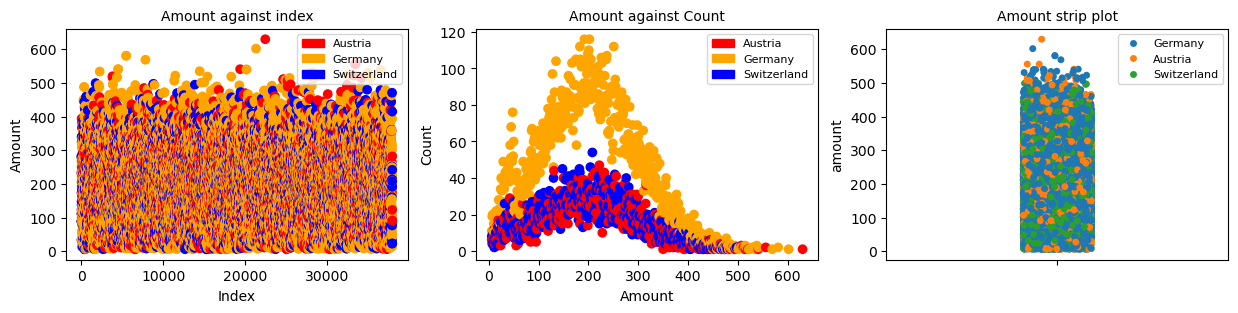

Compare success against country based on transactions count and values


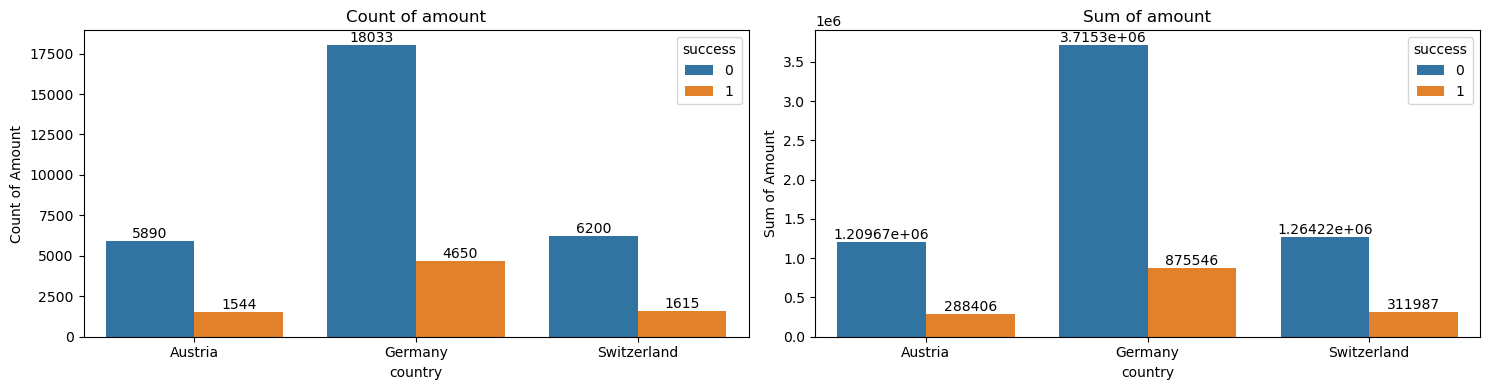

Stacked bar for success against country based on transactions count and values


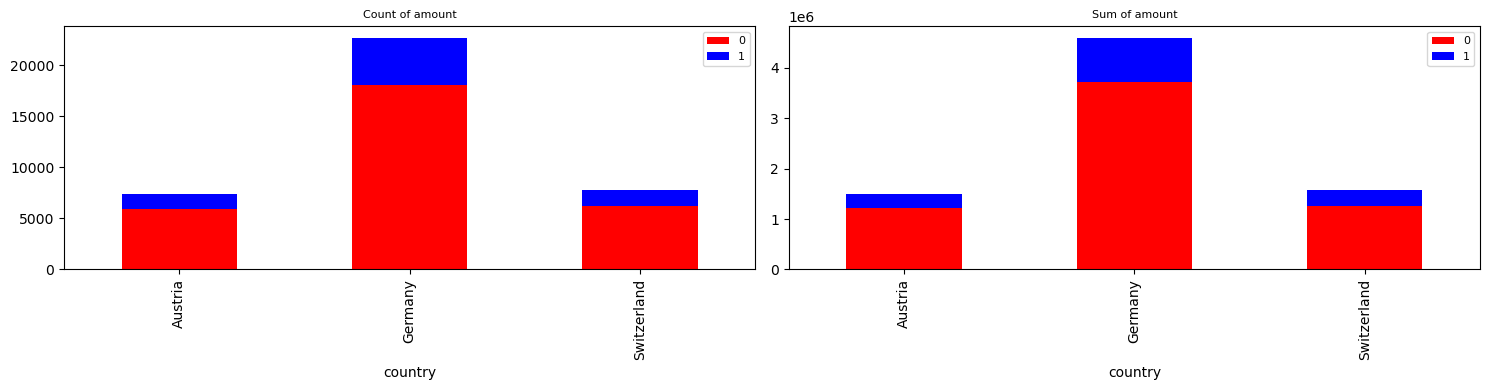

Success rate per country category
Success rate by category


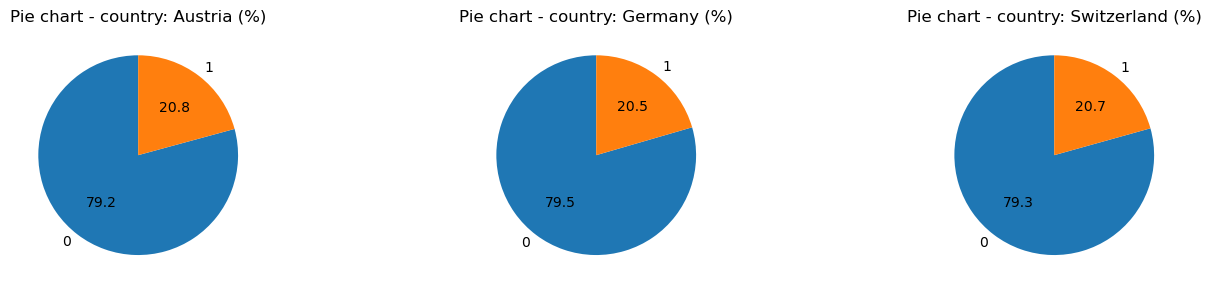

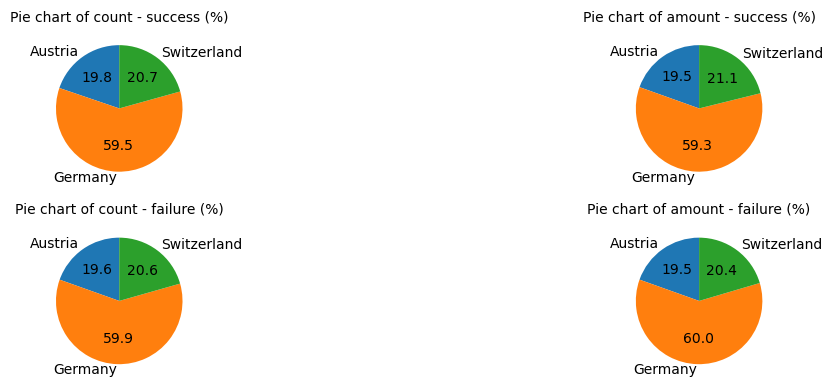

In [46]:
bivariate_analysis(dataset_time, 'country', {'Austria':'red', 'Germany':'orange', 'Switzerland':'blue'}, feature2='success')

##### biii2. Success rate analysis

Histogram - success and amount


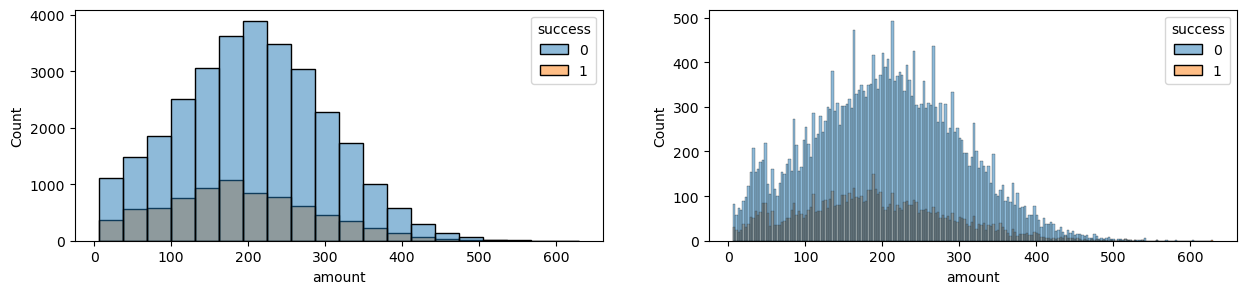

Scatter and strip plot - success and amount


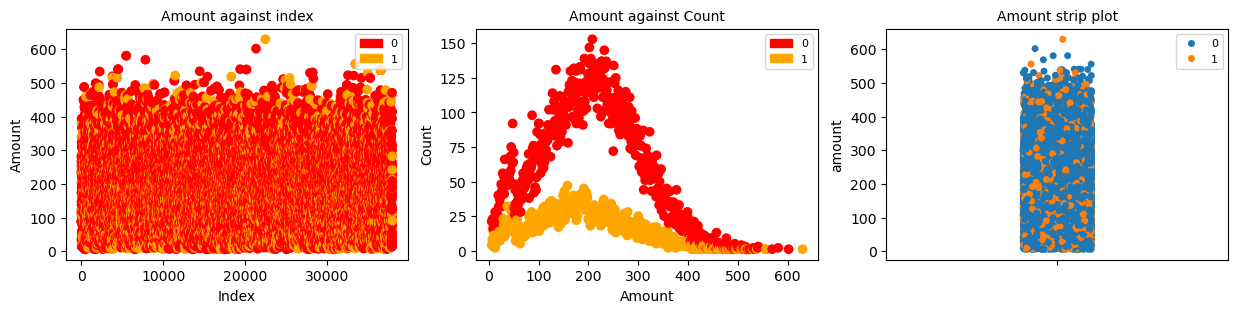

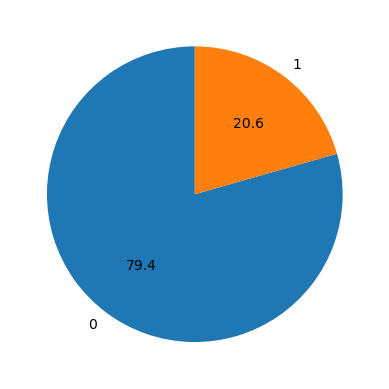

In [47]:
bivariate_analysis(dataset_time,'success', {0:'red', 1:'orange'})

##### biii3. PSP against amount and success rate

Histogram - PSP and amount


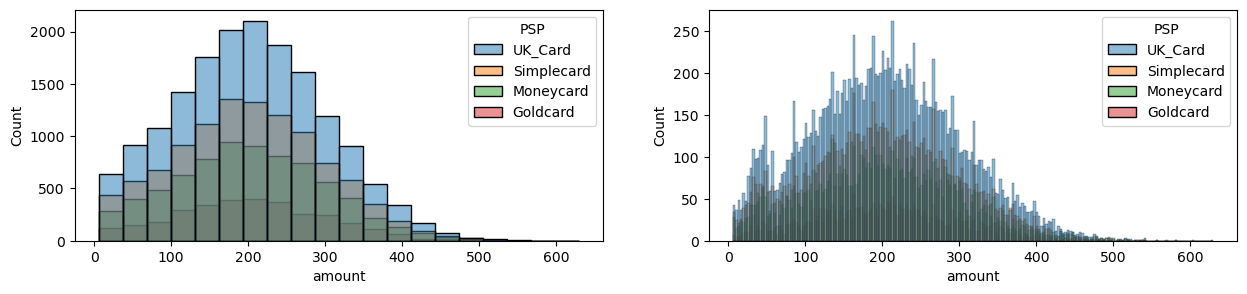

Scatter and strip plot - PSP and amount


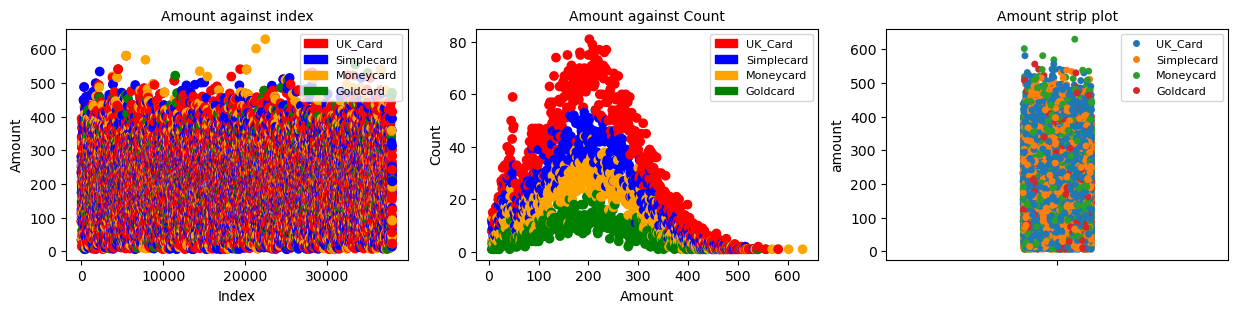

Compare success against PSP based on transactions count and values


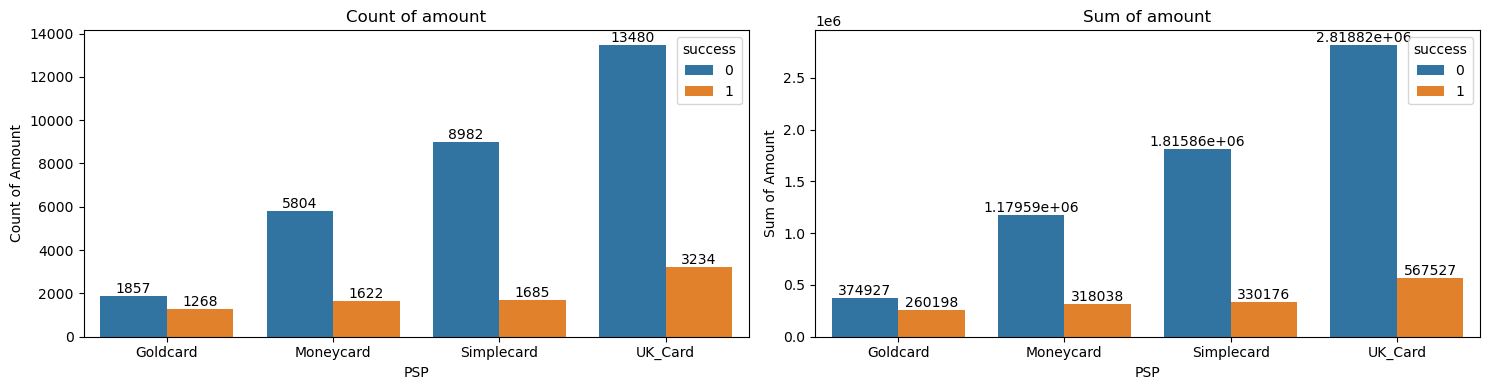

Stacked bar for success against PSP based on transactions count and values


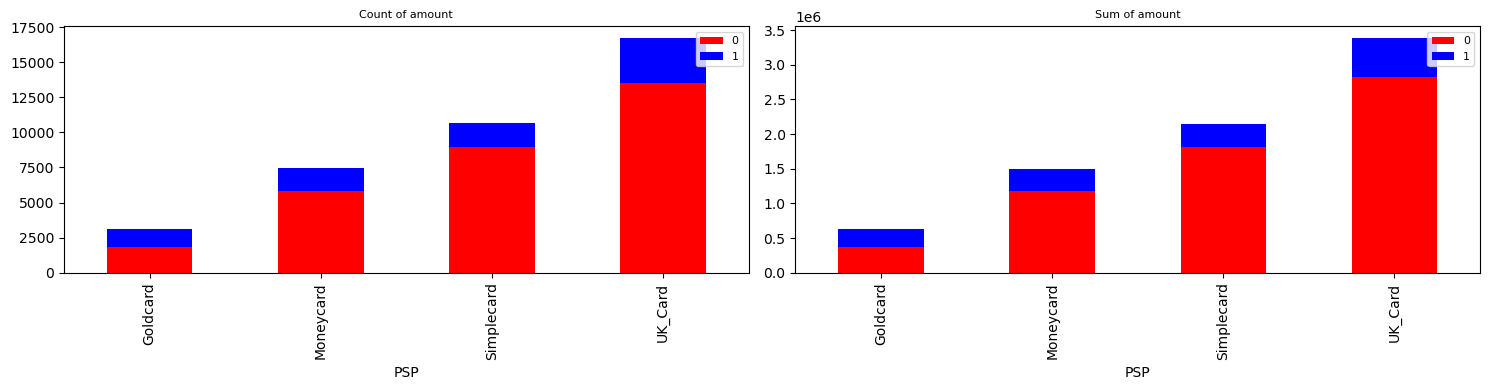

Success rate per PSP category
Success rate by category


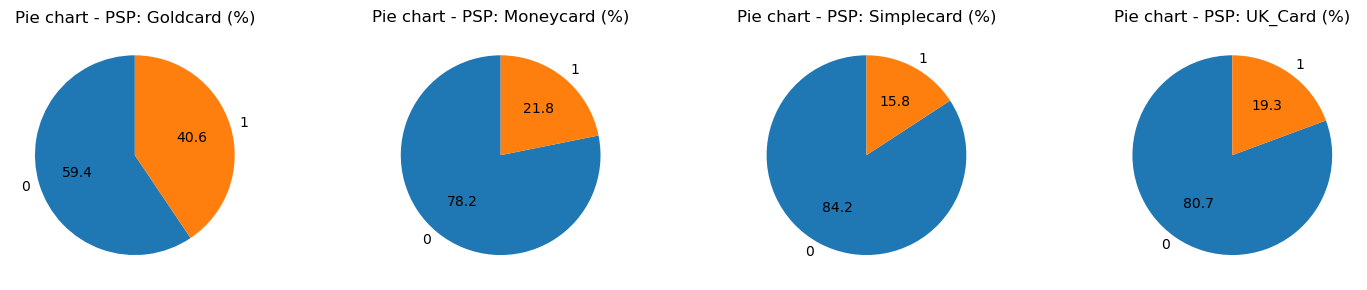

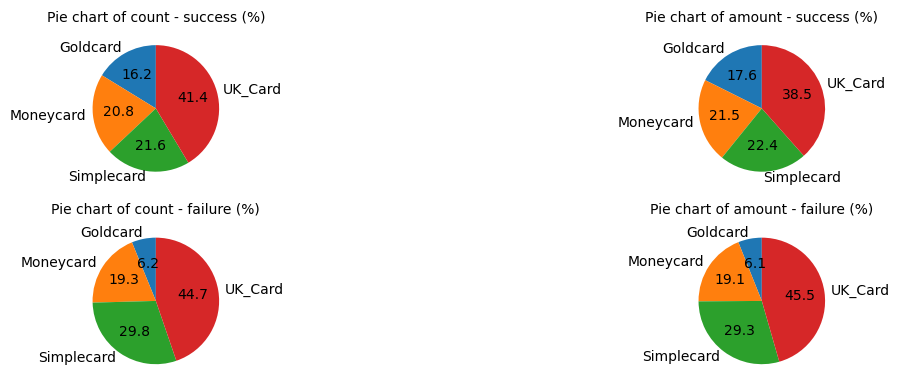

In [48]:
bivariate_analysis(dataset_time, 'PSP', {'UK_Card':'red', 'Simplecard':'blue', 'Moneycard':'orange','Goldcard':'green'}, feature2='success')

##### biii4. 3D_secured against amount and success rate

Histogram - 3D_secured and amount


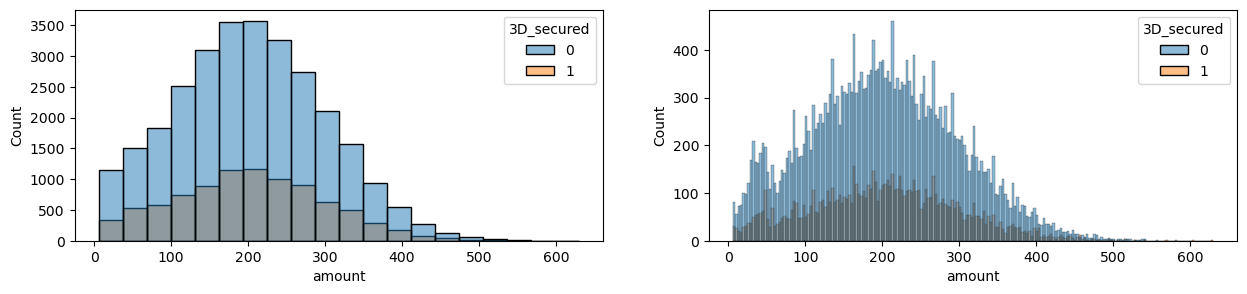

Scatter and strip plot - 3D_secured and amount


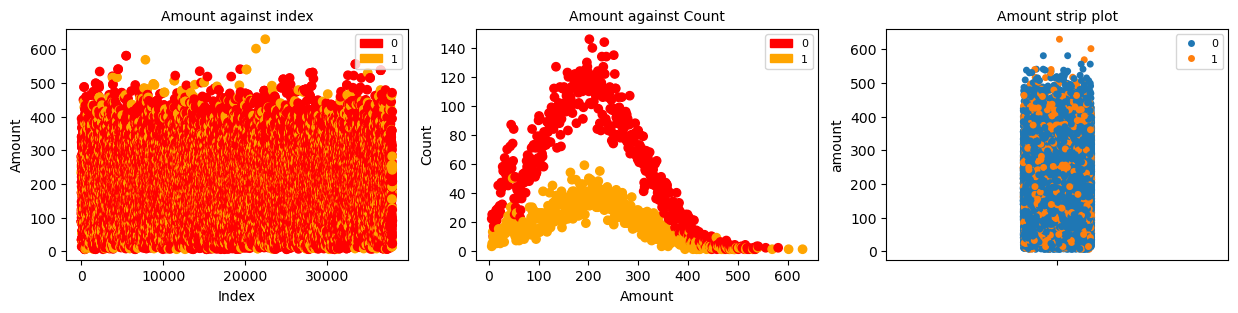

Compare success against 3D_secured based on transactions count and values


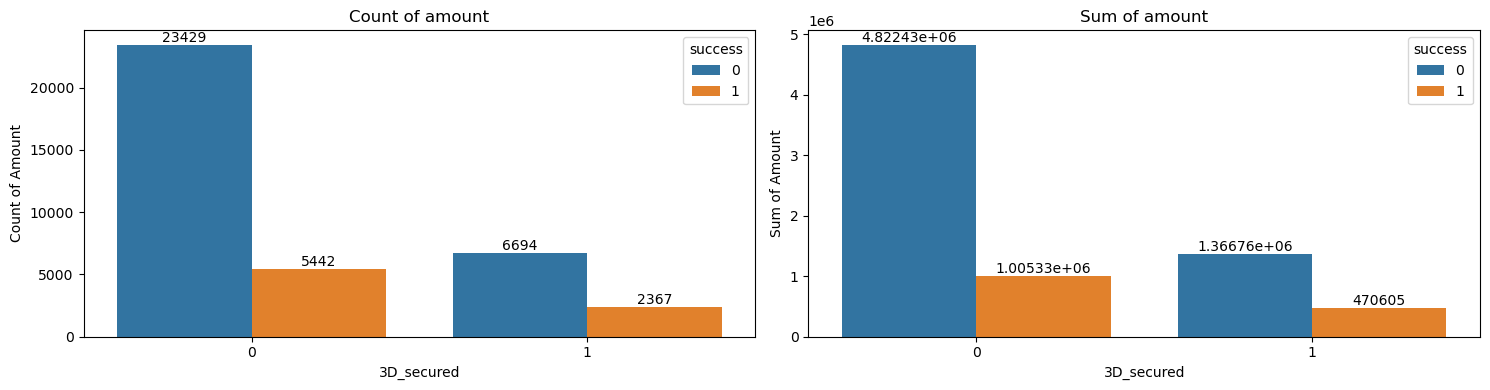

Stacked bar for success against 3D_secured based on transactions count and values


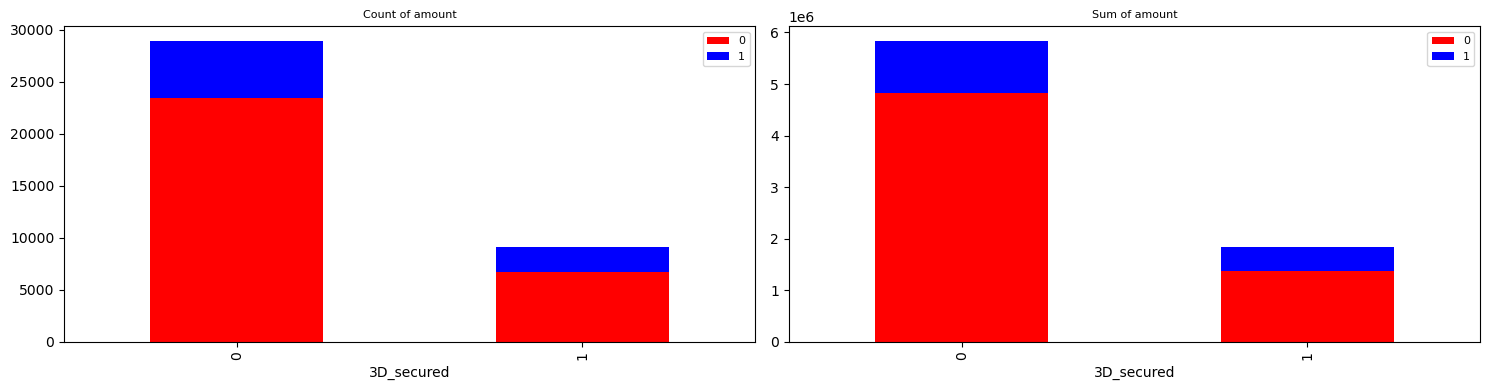

Success rate per 3D_secured category
Success rate by category


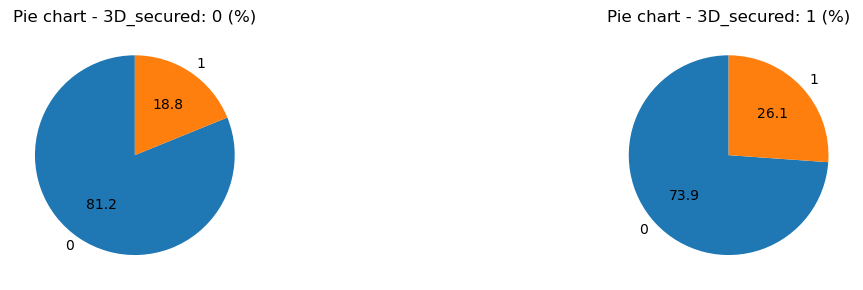

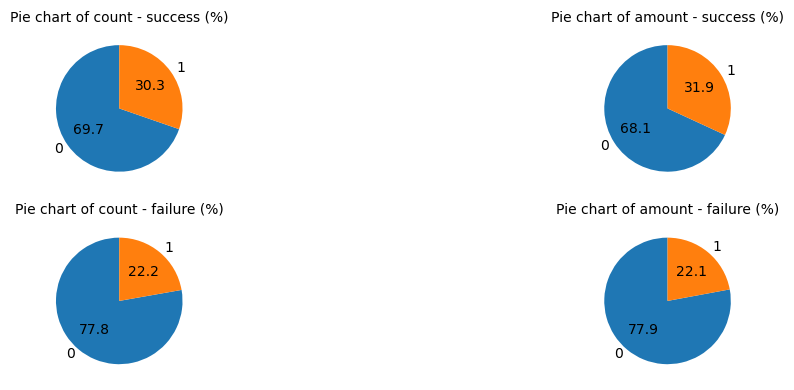

In [49]:
bivariate_analysis(dataset_time,'3D_secured', {0:'red', 1:'orange'}, feature2='success')

##### biii5. Card against amount and success rate

Histogram - card and amount


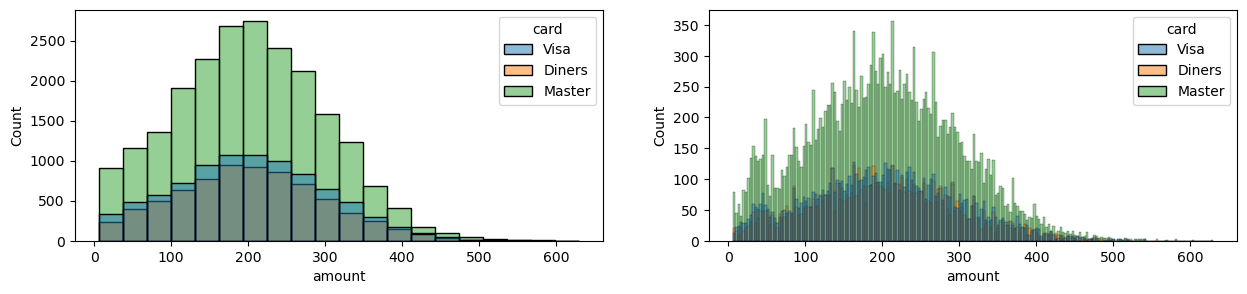

Scatter and strip plot - card and amount


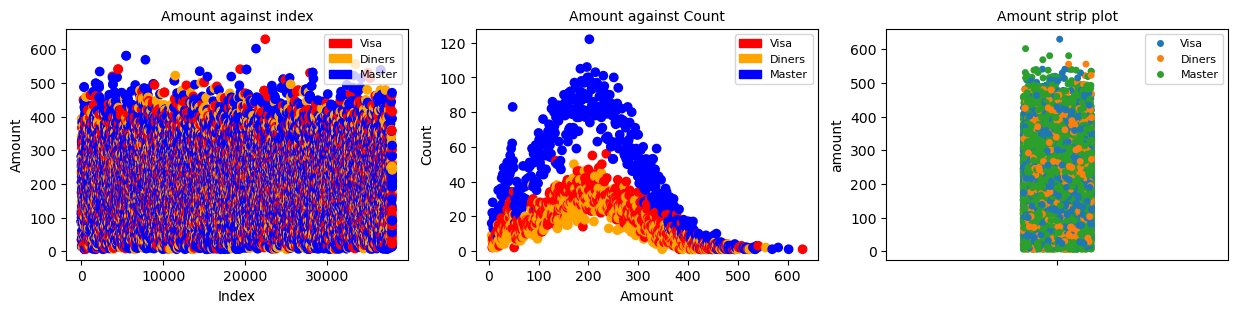

Compare success against card based on transactions count and values


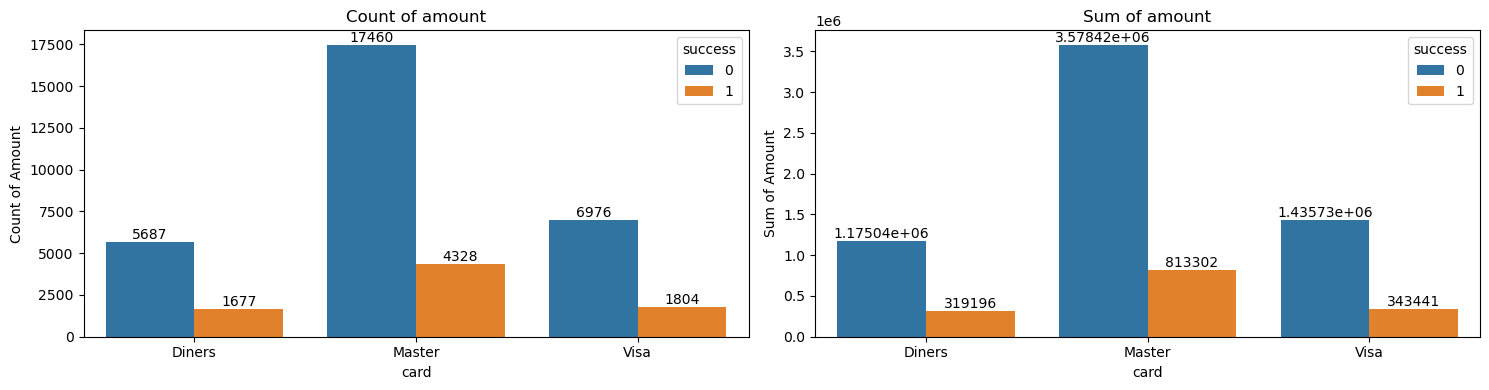

Stacked bar for success against card based on transactions count and values


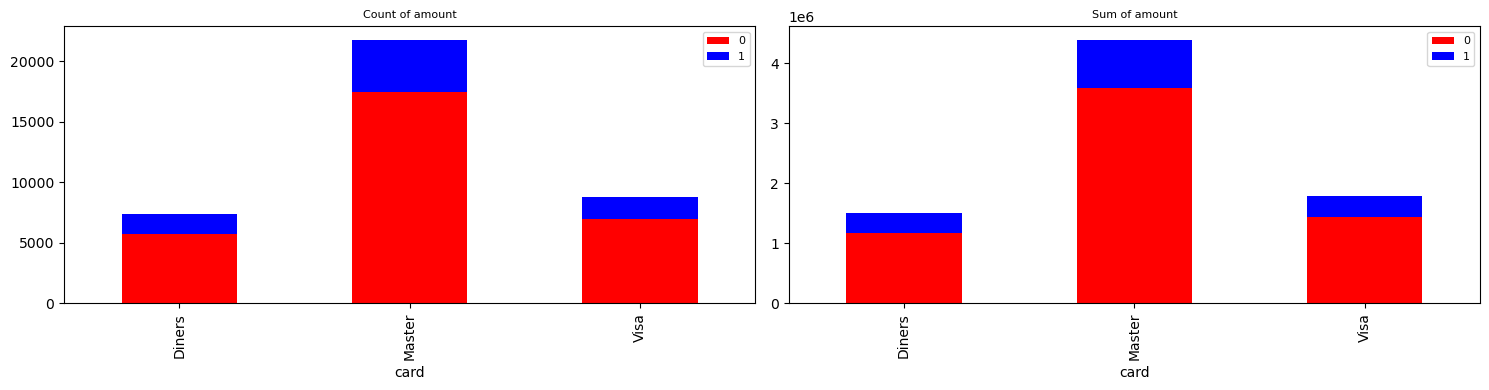

Success rate per card category
Success rate by category


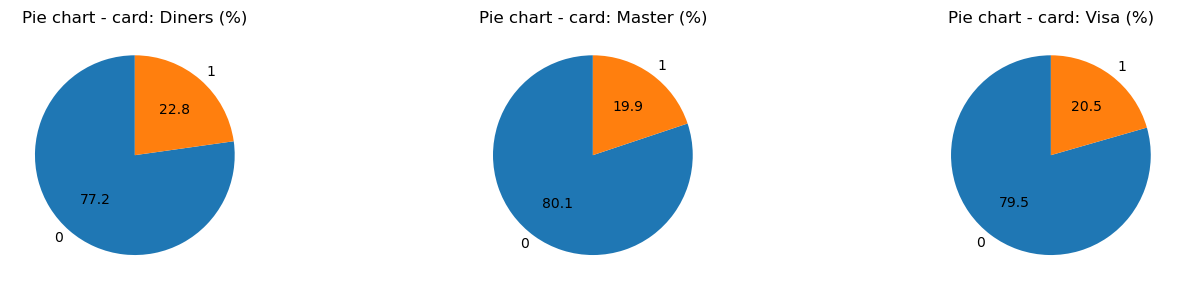

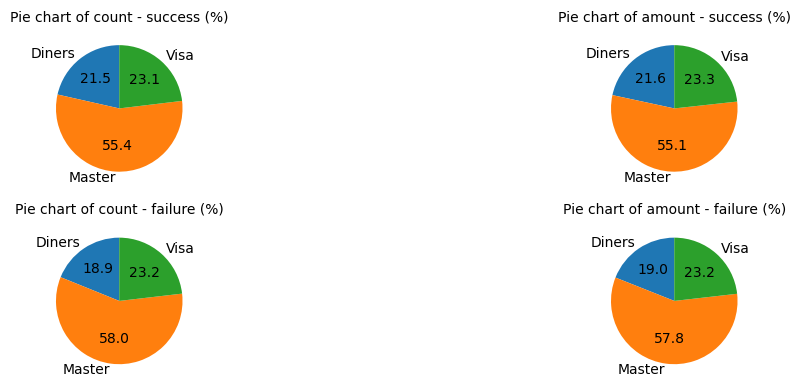

In [50]:
bivariate_analysis(dataset_time, 'card', {'Visa':'red', 'Diners':'orange', 'Master':'blue'}, feature2='success')

### 3biv. Pairplot analysis

<Figure size 700x400 with 0 Axes>

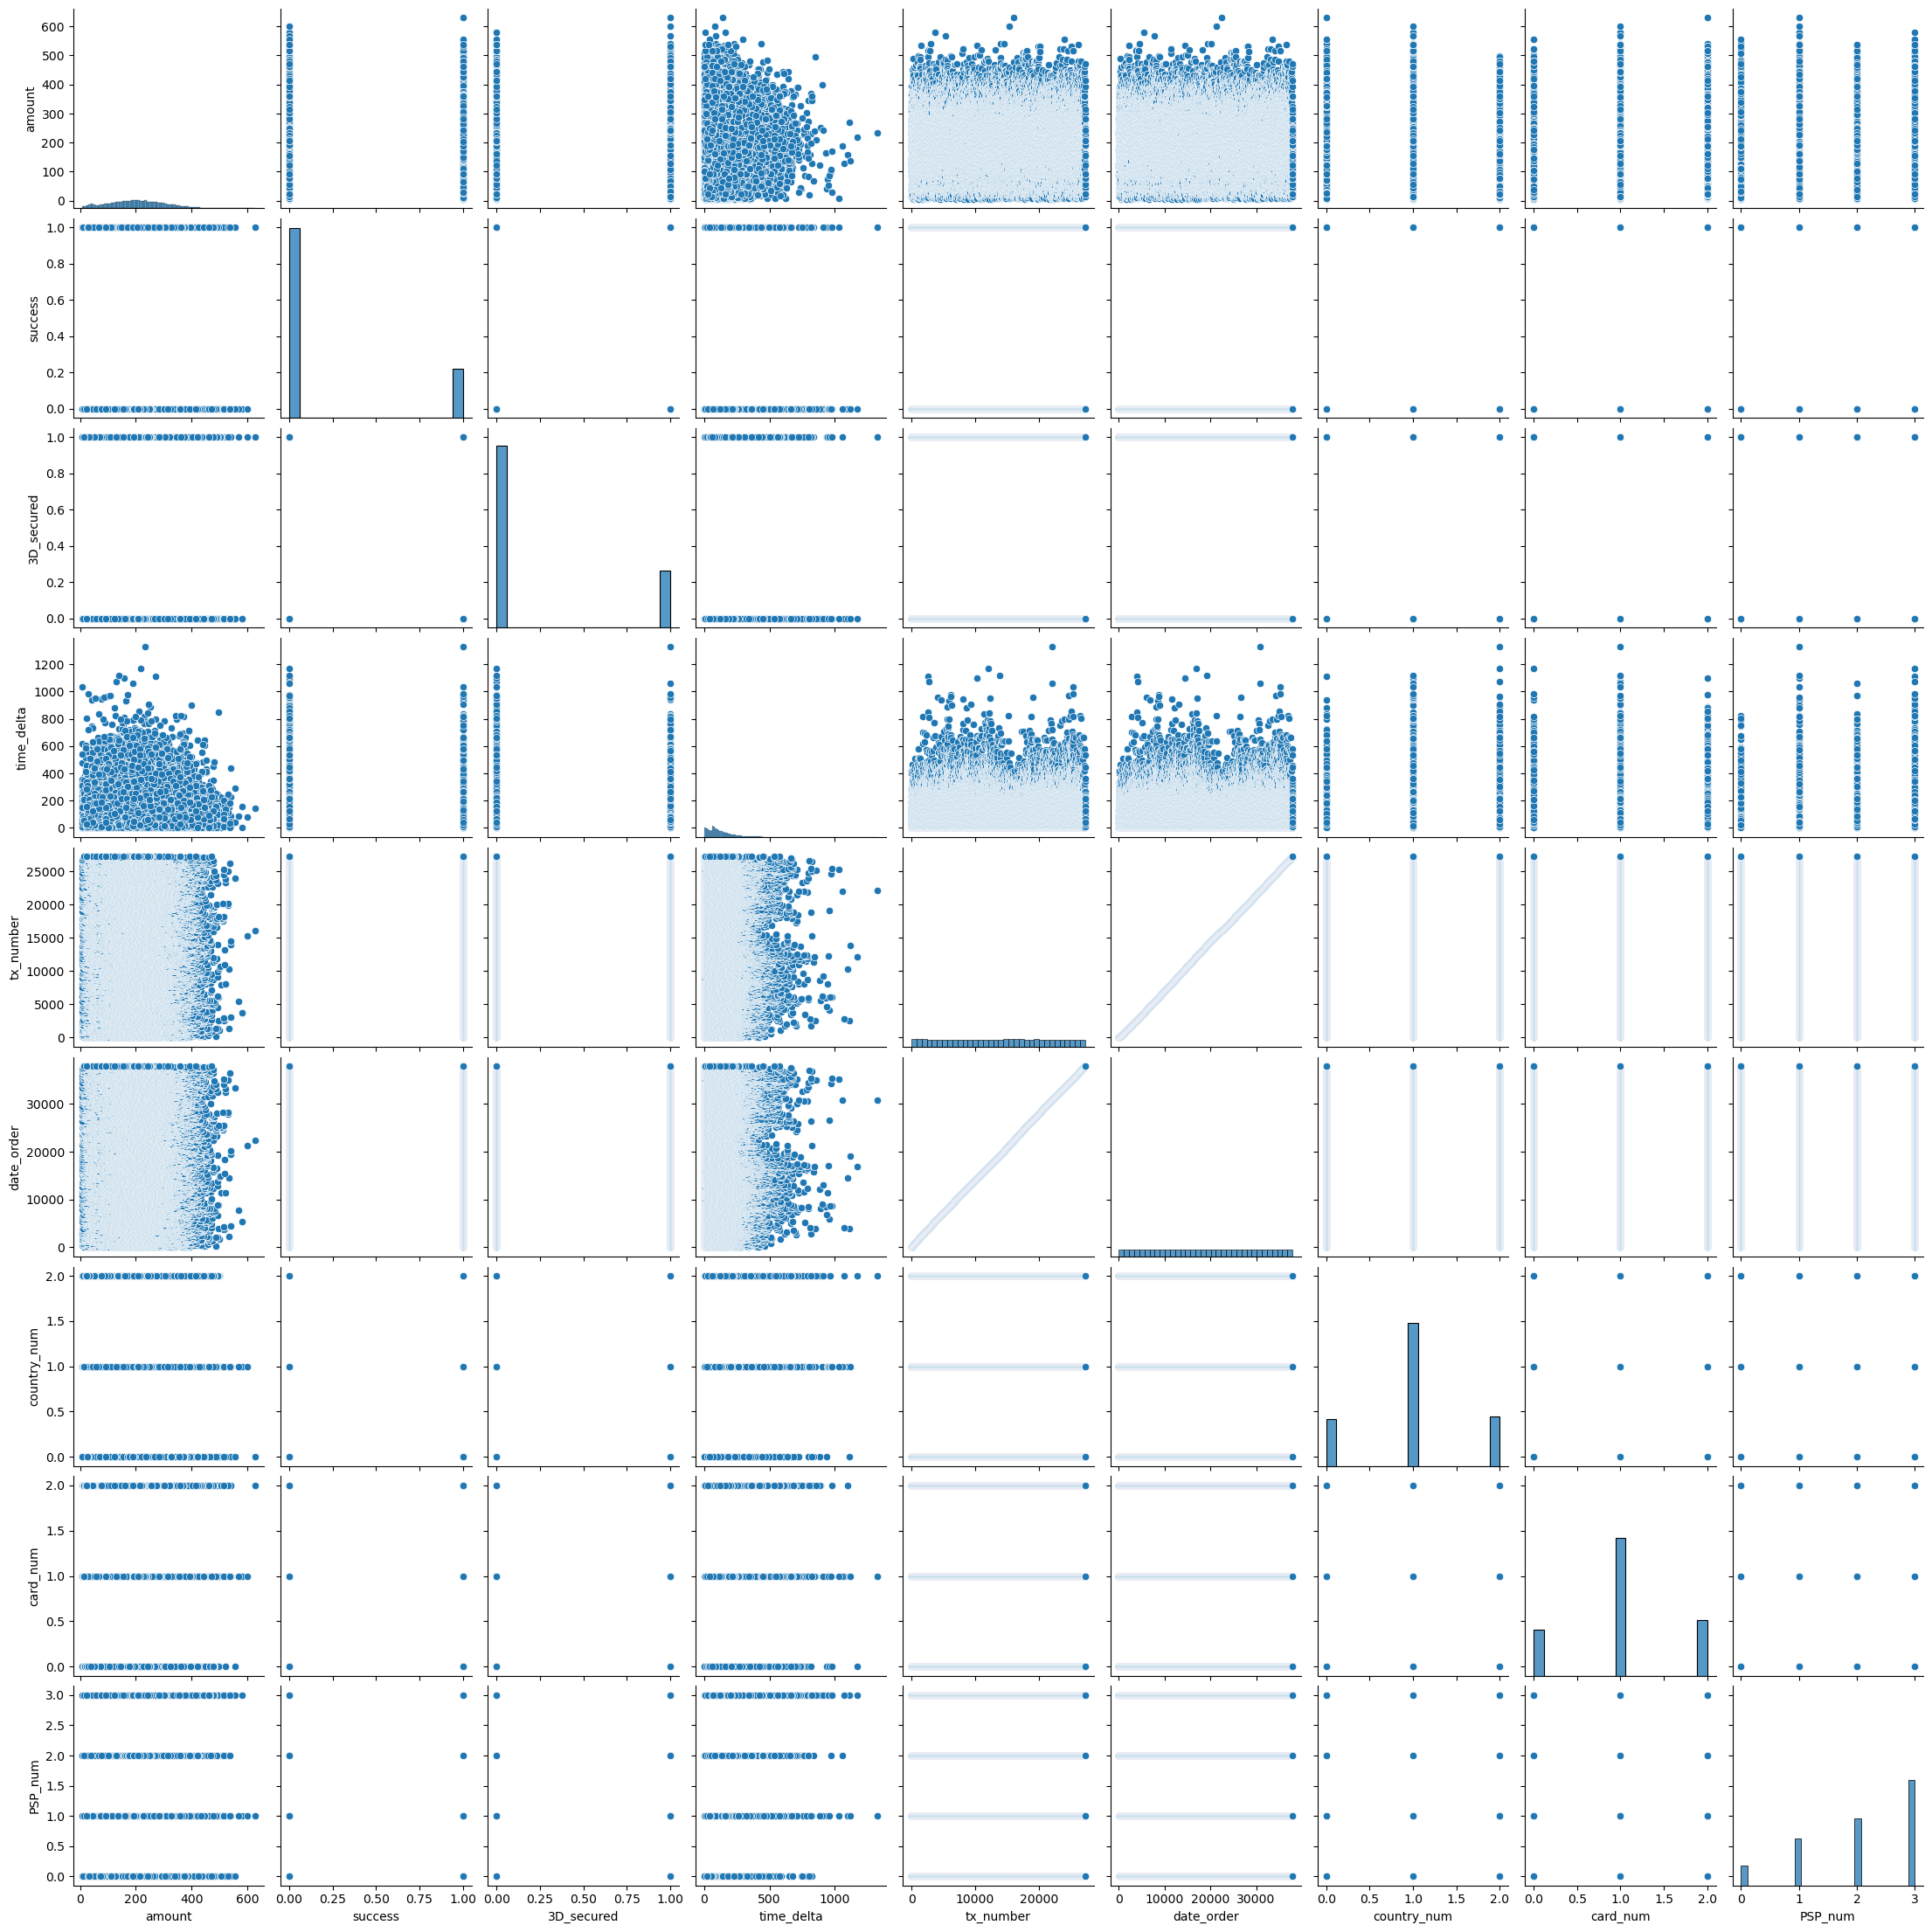

In [51]:
plt.figure(figsize = (7,4))
sns.pairplot(dataset_time)
plt.show()

<Figure size 700x400 with 0 Axes>

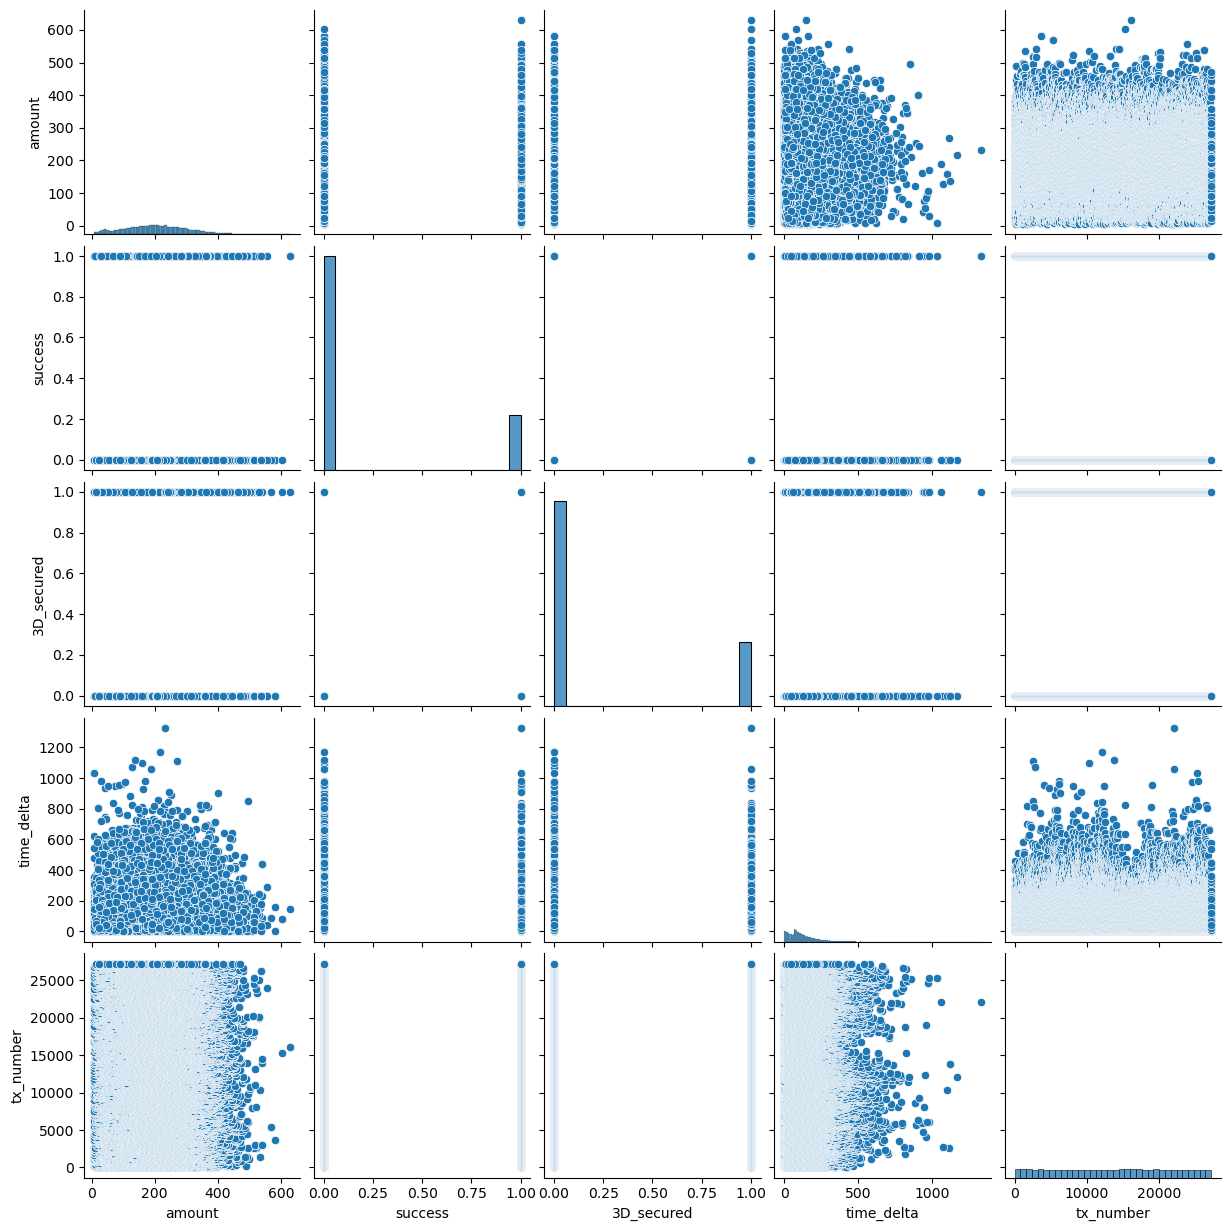

In [52]:
plt.figure(figsize = (7,4))
sns.pairplot(dataset_time.drop(['date_order', 'country_num', 'PSP_num', 'card_num'],axis=1))
plt.show()

### 3bv. Correlation heatmap

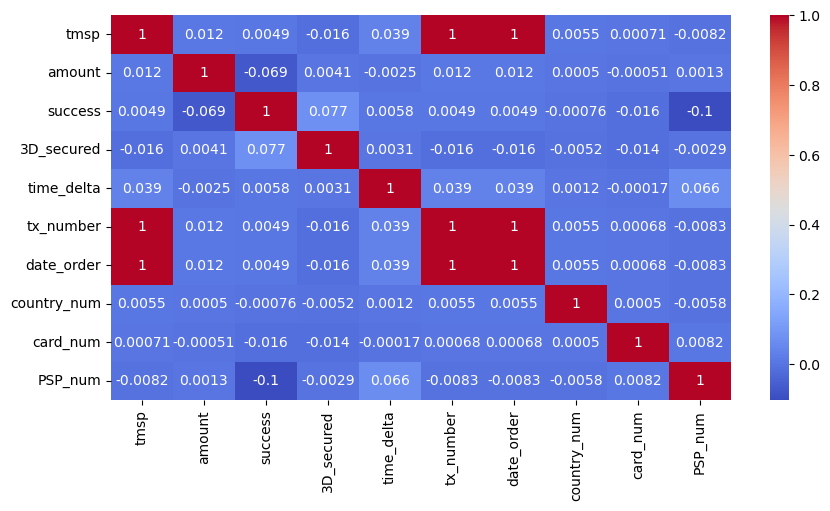

In [53]:
plt.figure(figsize = (10,5))
correlation_matrix = dataset_time.drop(['country', 'PSP', 'card'],axis=1).corr()
sns.heatmap(correlation_matrix, cmap = 'coolwarm', annot=True)
plt.show()

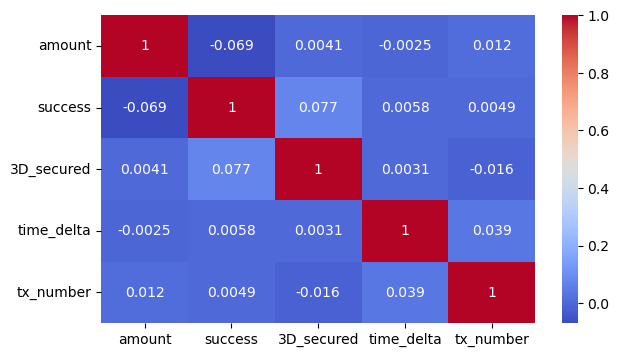

In [54]:
plt.figure(figsize = (7,4))
correlation_matrix = dataset_time.drop(['country', 'PSP', 'card', 'date_order', 'country_num', 'PSP_num', 'card_num', 'tmsp'],axis=1).corr()
sns.heatmap(correlation_matrix, cmap = 'coolwarm', annot=True)
plt.show()

### 3bvi. Bivariate analysis of PSP against the other independent variables

##### bvi1. PSP against country

Compare PSP against country based on transactions count and values


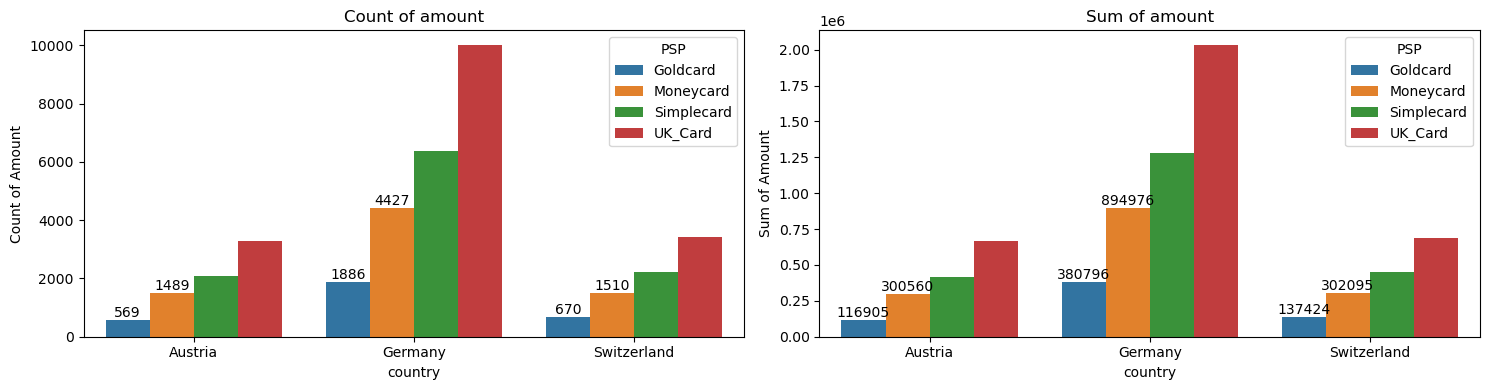

Stacked bar for PSP against country based on transactions count and values


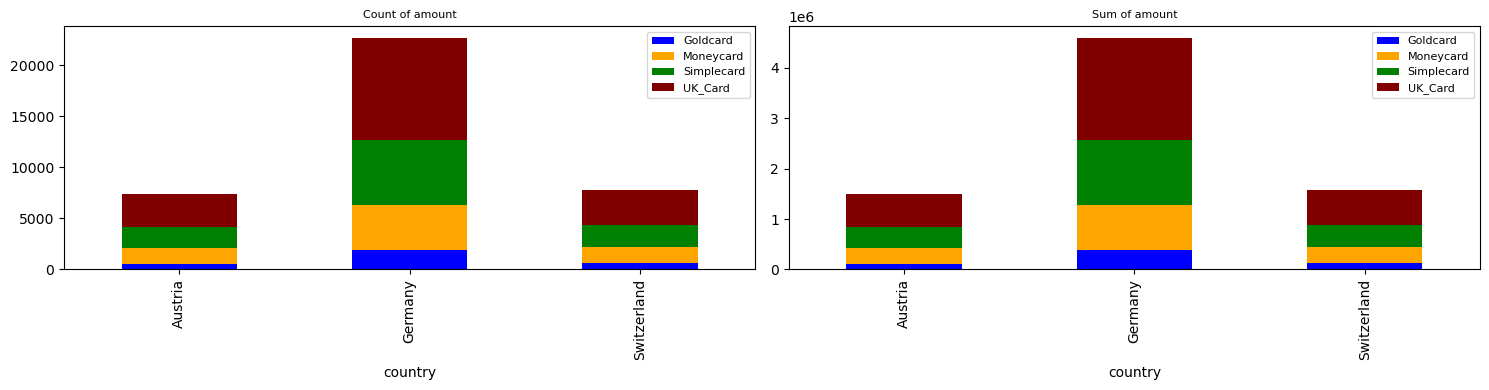

PSP per country category


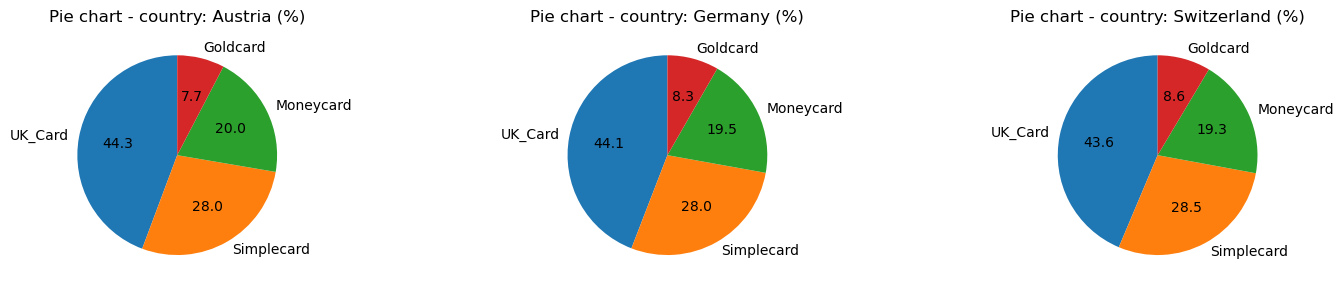

In [55]:
# PSP against country
bivariate_analysis(dataset_time, 'country', {'Austria':'red', 'Germany':'orange', 'Switzerland':'blue'}, feature2='PSP', 
                   color_list=['blue', 'orange', 'green', 'maroon'])

##### bvi2. PSP against success

Compare PSP against success based on transactions count and values


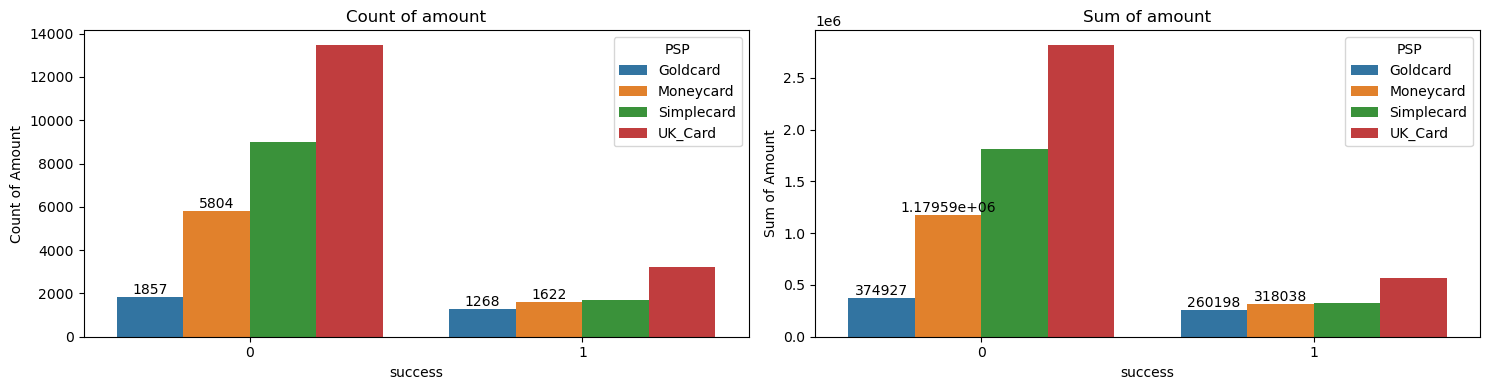

Stacked bar for PSP against success based on transactions count and values


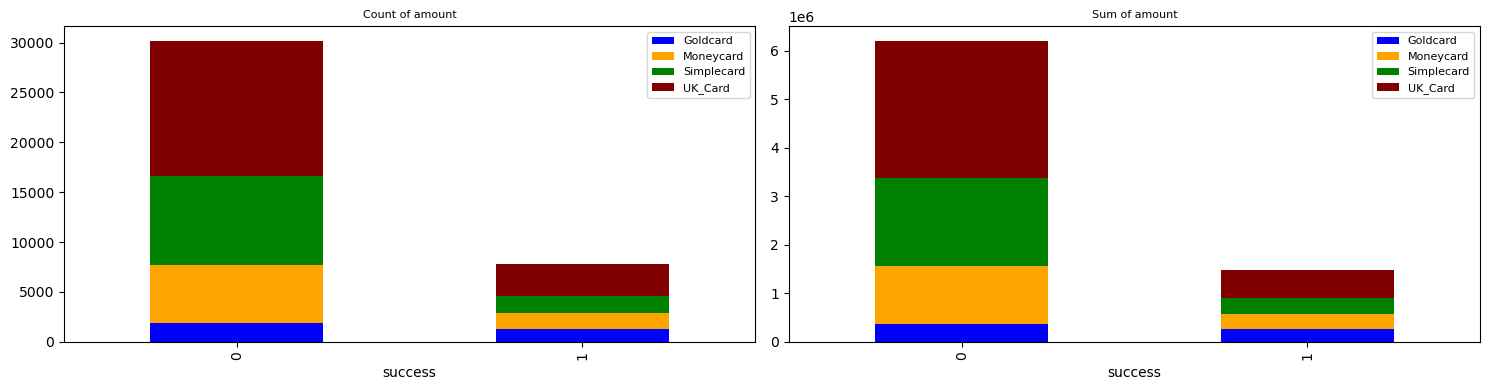

PSP per success category


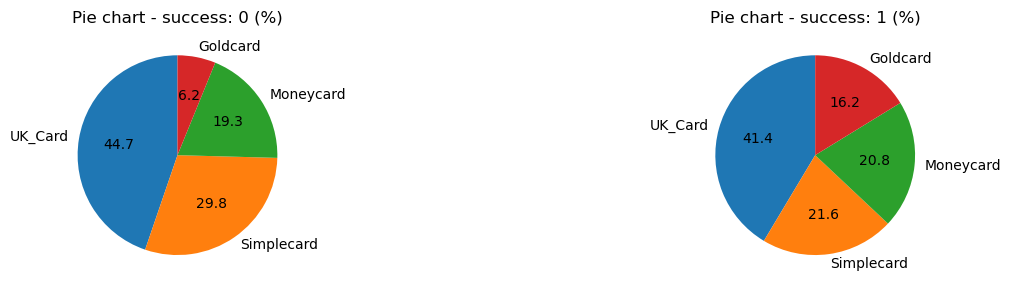

In [56]:
# PSP against success
bivariate_analysis(dataset_time,'success', {0:'red', 1:'orange'}, feature2='PSP', color_list=['blue', 'orange', 'green', 'maroon'])

##### bvi3. PSP against 3D_secured

Compare PSP against 3D_secured based on transactions count and values


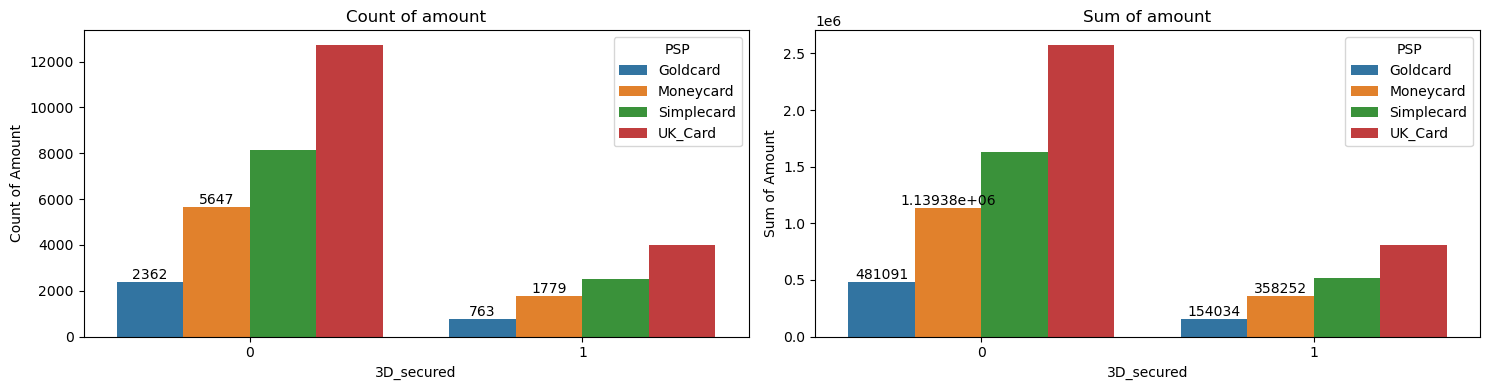

Stacked bar for PSP against 3D_secured based on transactions count and values


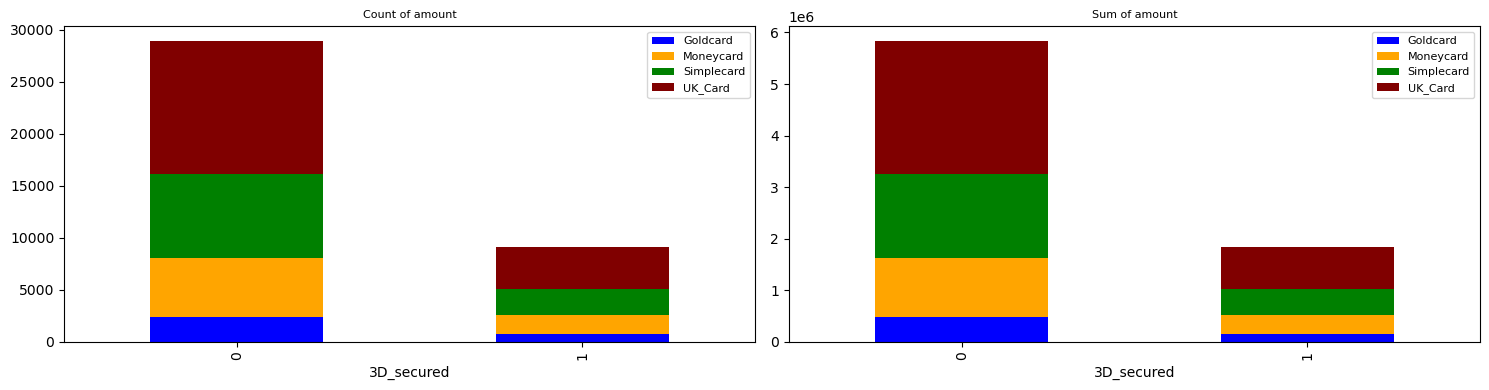

PSP per 3D_secured category


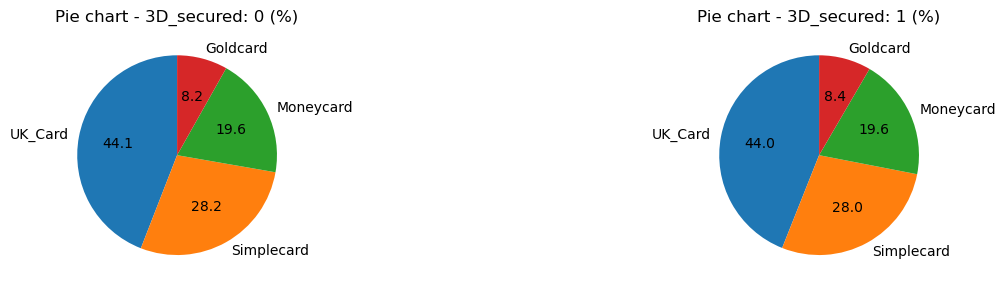

In [57]:
# PSP against 3D_secured
bivariate_analysis(dataset_time,'3D_secured', {0:'red', 1:'orange'}, feature2='PSP', color_list=['blue', 'orange', 'green', 'maroon'])

##### bvi4. PSP against card

Compare PSP against card based on transactions count and values


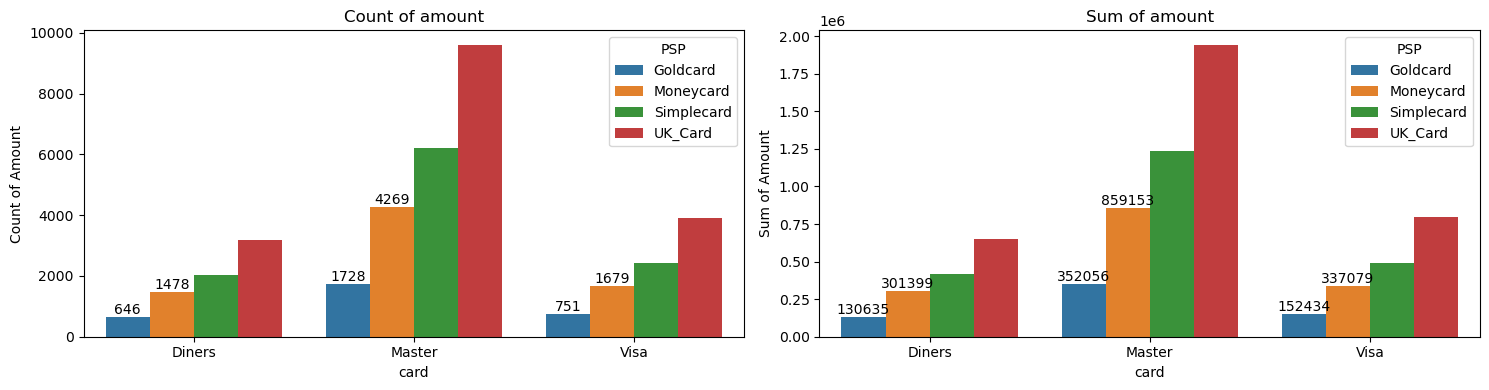

Stacked bar for PSP against card based on transactions count and values


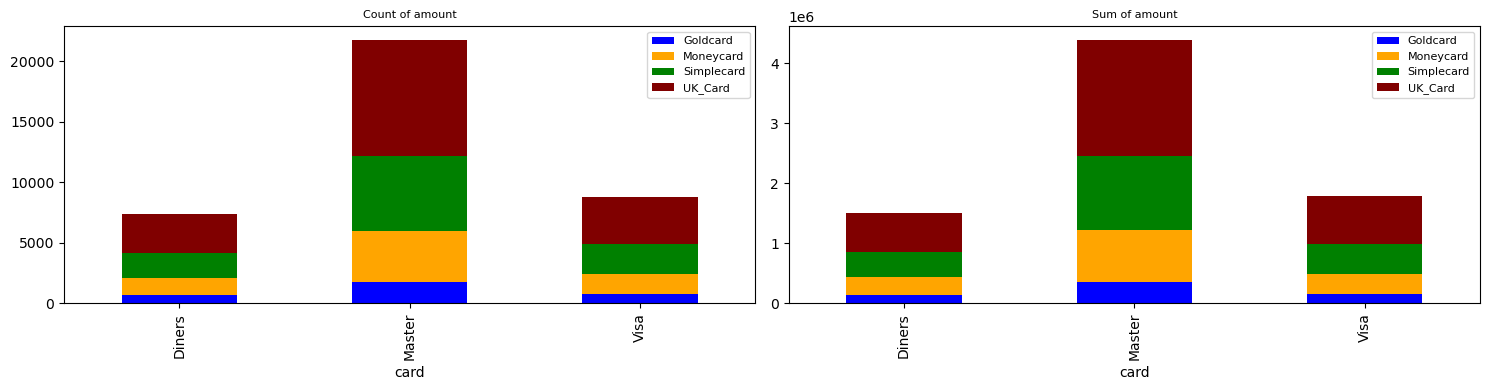

PSP per card category


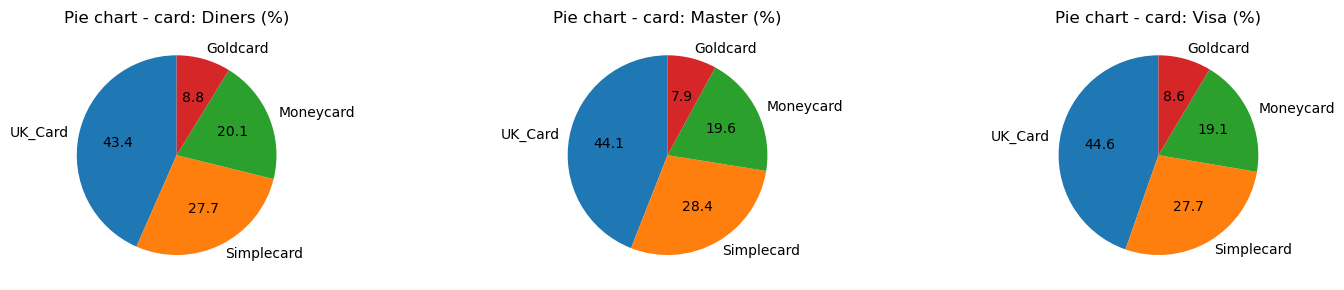

In [58]:
# PSP against card
bivariate_analysis(dataset_time, 'card', {'Visa':'red', 'Diners':'orange', 'Master':'blue'}, feature2='PSP', 
                   color_list=['blue', 'orange', 'green', 'maroon'])

### 3bvii. Bivariate analysis of 3D_secured against PSP

##### bvii1. 3D_secured against PSP

Compare 3D_secured against PSP based on transactions count and values


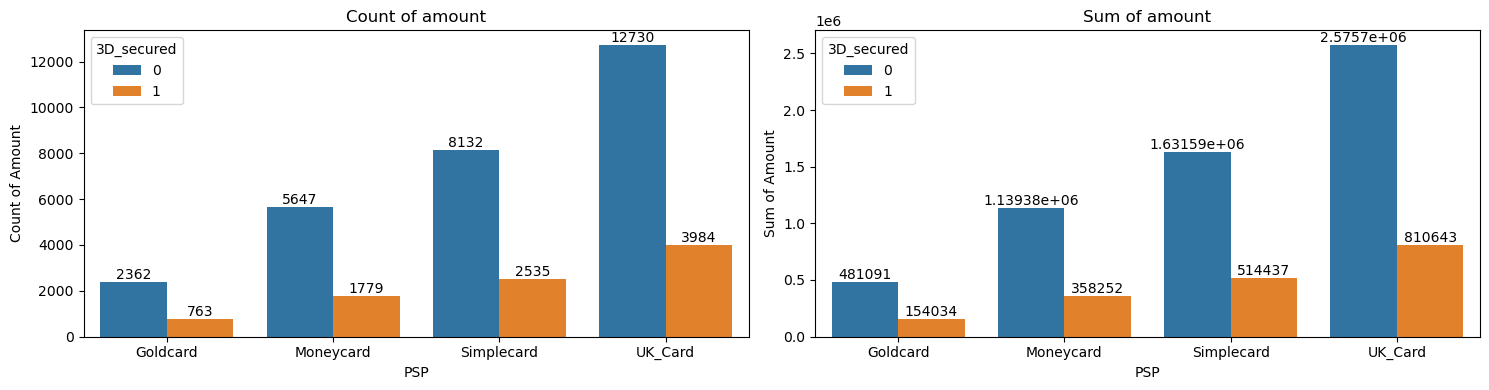

Stacked bar for 3D_secured against PSP based on transactions count and values


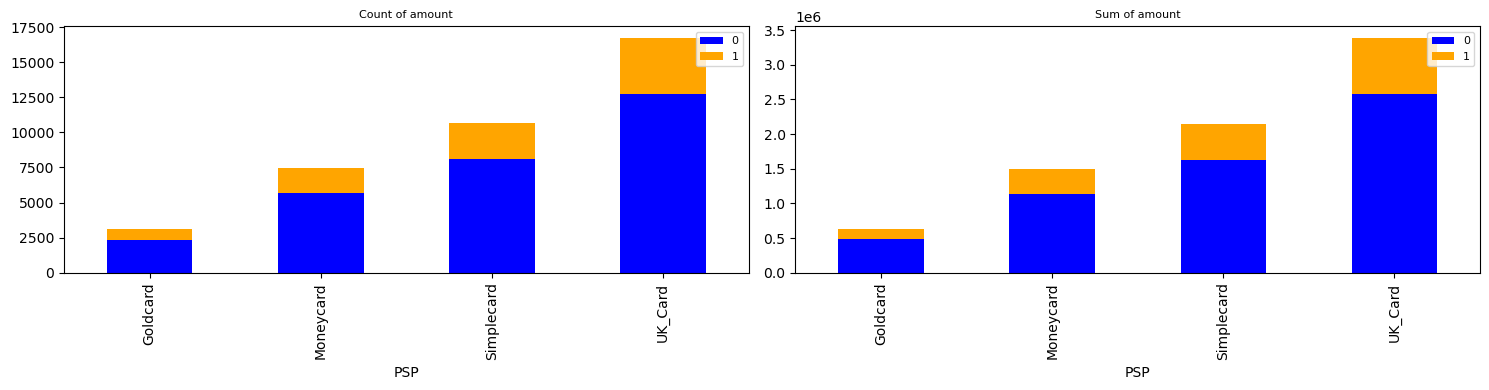

3D_secured per PSP category


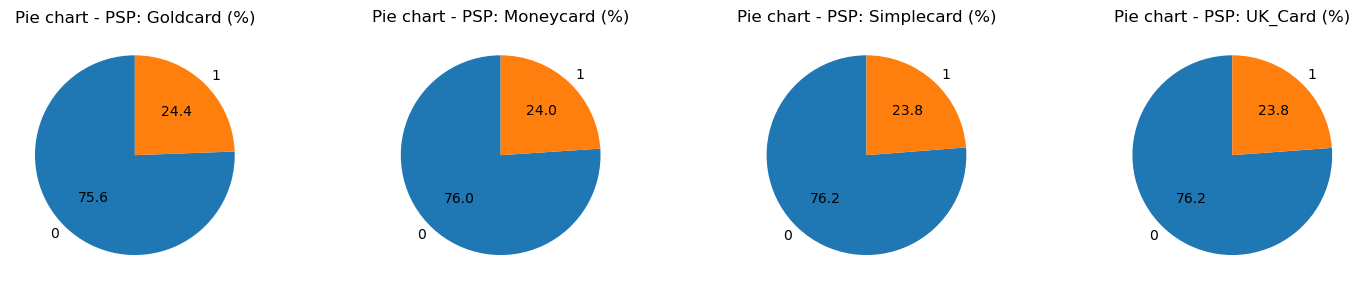

In [59]:
# PSP against card
bivariate_analysis(dataset_time, 'PSP', {'UK_Card':'red', 'Simplecard':'blue', 'Moneycard':'orange','Goldcard':'green'}, feature2='3D_secured', 
                   color_list=['blue', 'orange', 'green', 'maroon'], labels=['0', '1'])

##### bvii2. 3D_secured against PSP for failed transactions only

Compare 3D_secured against PSP based on transactions count and values


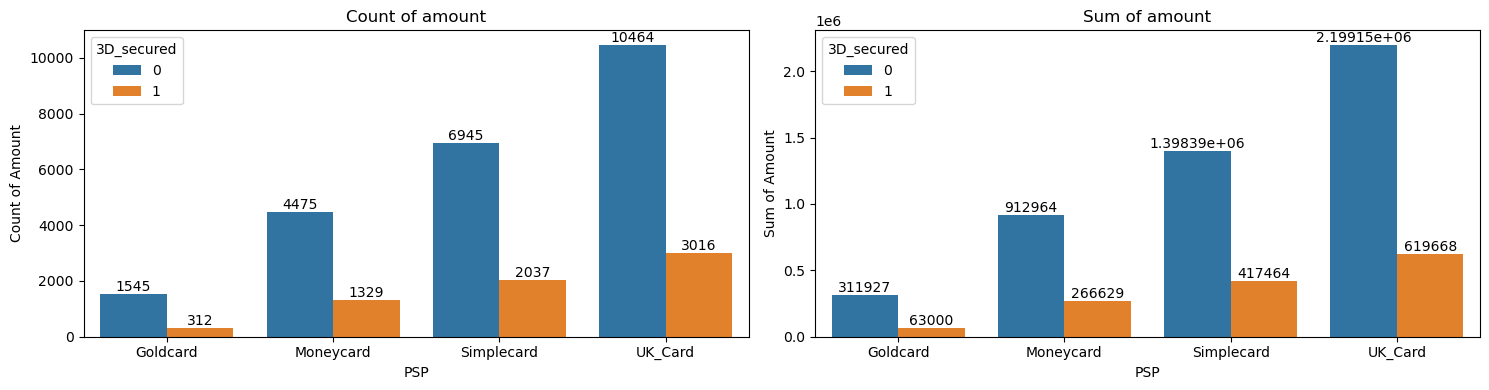

Stacked bar for 3D_secured against PSP based on transactions count and values


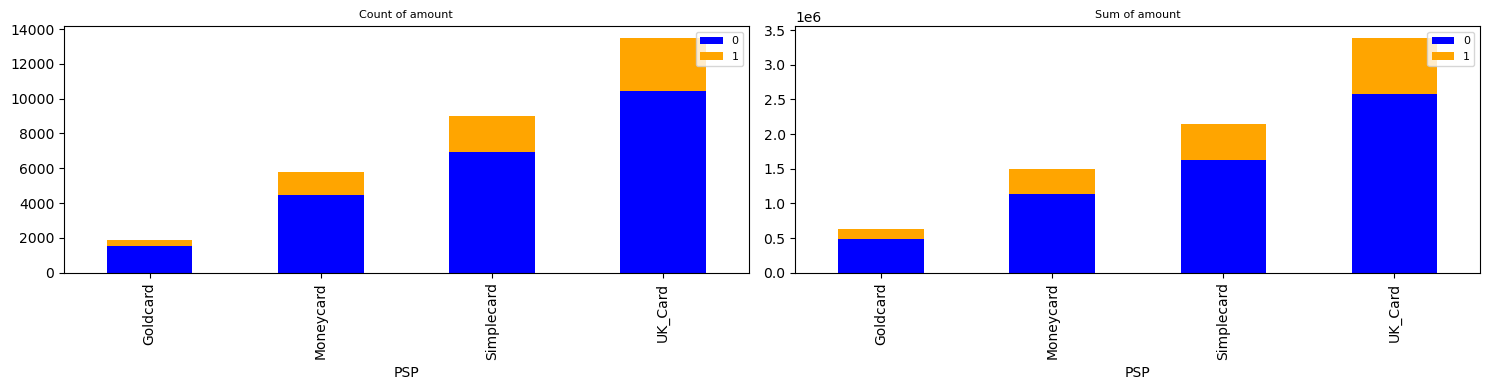

3D_secured per PSP category


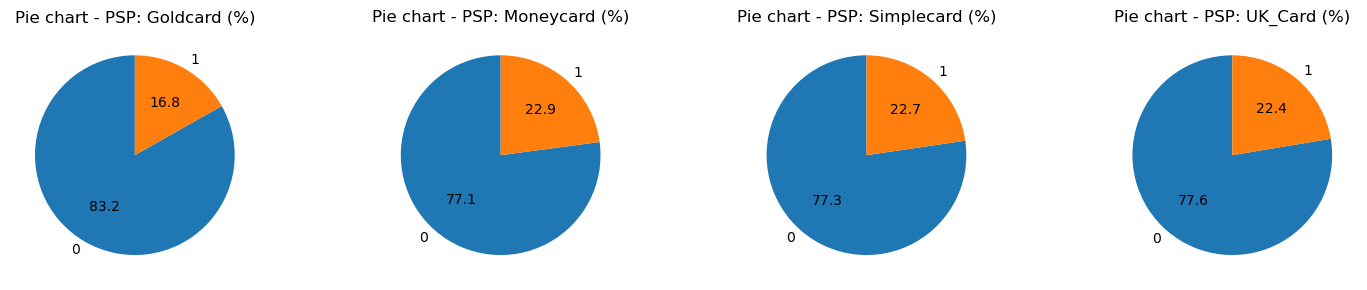

In [60]:
bivariate_analysis(dataset_time[dataset_time['success']==0], 'PSP', {'UK_Card':'red', 'Simplecard':'blue', 'Moneycard':'orange','Goldcard':'green'}, 
                   feature2='3D_secured', color_list=['blue', 'orange', 'green', 'maroon'], labels=['0', '1'])

##### bvii3. 3D_secured against PSP for successful transactions only

Compare 3D_secured against PSP based on transactions count and values


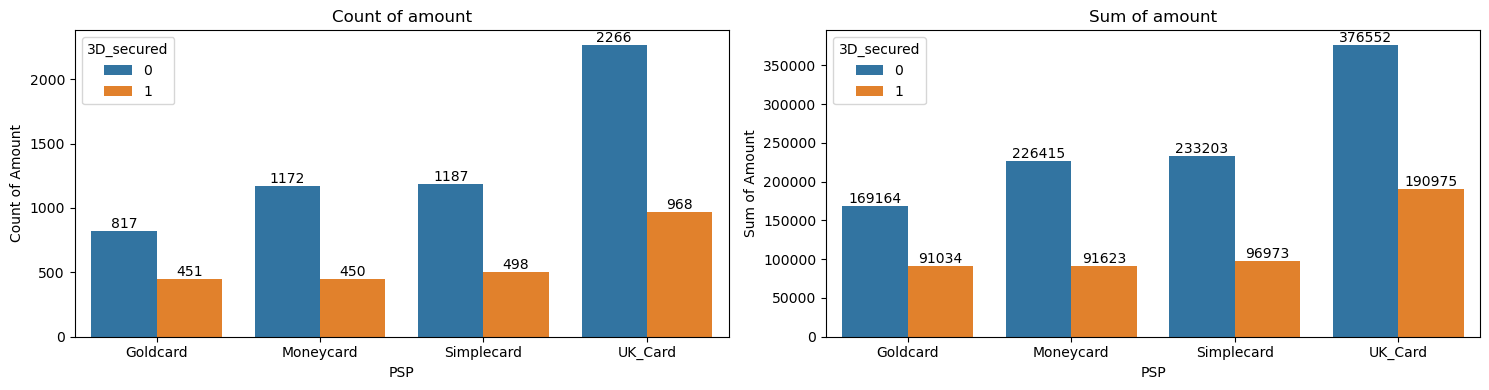

Stacked bar for 3D_secured against PSP based on transactions count and values


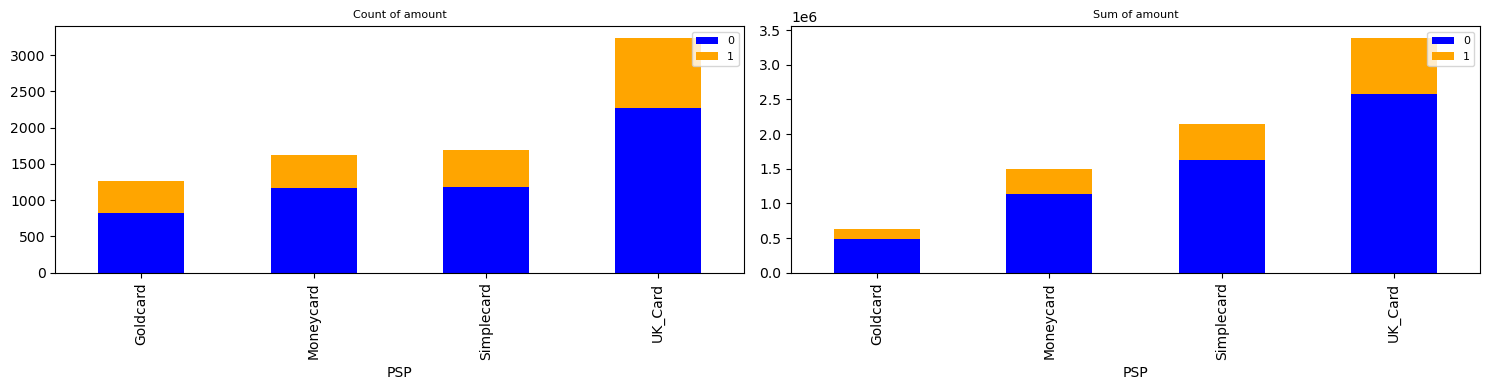

3D_secured per PSP category


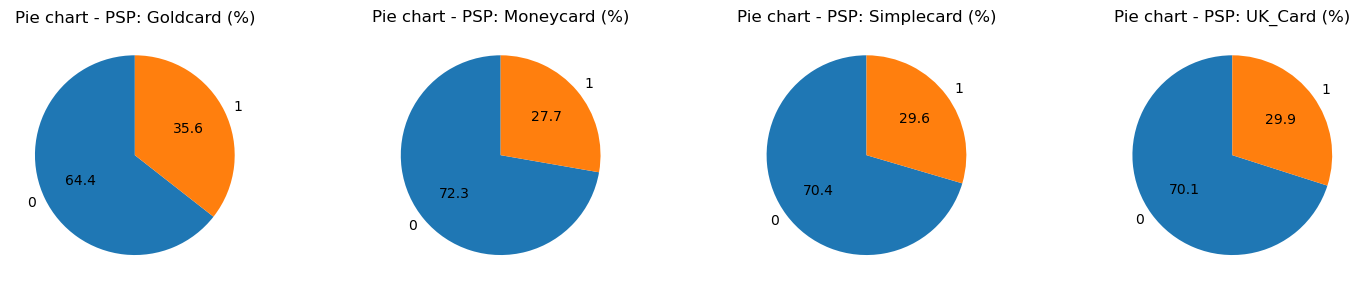

In [61]:
bivariate_analysis(dataset_time[dataset_time['success']==1], 'PSP', {'UK_Card':'red', 'Simplecard':'blue', 'Moneycard':'orange','Goldcard':'green'}, 
                   feature2='3D_secured', color_list=['blue', 'orange', 'green', 'maroon'], labels=['0', '1'])